In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchbearer import Trial

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

SGD with Heavy Ball

In [0]:
import torch
from torch.optim.optimizer import Optimizer, required


class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
             v = \rho * v + lr * g \\
             p = p - v

        The Nesterov version is analogously modified.
    """
    #add heavy ball flag into dict param list
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, heavy_ball=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        #deal with heavy ball flag
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, 
                        heavy_ball=heavy_ball)
        
        #read heavy ball flag
        if heavy_ball and (momentum <= 0 or dampening != 0):
            raise ValueError("Heavy-ball momentum requires a momentum and zero dampening")

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('heavy_ball', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            #read heavy ball flag
            heavy_ball = group['heavy_ball']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        #init prev momentum space in GPU
                        param_state['prev_momentum_buffer'] = torch.zeros(buf.size()).cuda()
                    else:
                        buf = param_state['momentum_buffer']
                        #heavy ball iteration
                        prev_buf = param_state['prev_momentum_buffer']
                        if heavy_ball:
                            temp = buf
                            buf.add_(-prev_buf).mul_(momentum).add_(1 - dampening, d_p)
                            param_state['prev_momentum_buffer'] = temp
                        else:
                            buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss


AccSGD

In [0]:
from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

44 layers Pre Active ResNet

In [0]:
import torch
import torch.nn as nn

class DownsampleA(nn.Module):  

  def __init__(self, nIn, nOut, stride):
    super(DownsampleA, self).__init__() 
    assert stride == 2    
    self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)   

  def forward(self, x):   
    x = self.avg(x)  
    return torch.cat((x, x.mul(0)), 1)  

class DownsampleC(nn.Module):     

  def __init__(self, nIn, nOut, stride):
    super(DownsampleC, self).__init__()
    assert stride != 1 or nIn != nOut
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=1, stride=stride, padding=0, bias=False)

  def forward(self, x):
    x = self.conv(x)
    return x

class DownsampleD(nn.Module):

  def __init__(self, nIn, nOut, stride):
    super(DownsampleD, self).__init__()
    assert stride == 2
    self.conv = nn.Conv2d(nIn, nOut, kernel_size=2, stride=stride, padding=0, bias=False)
    self.bn   = nn.BatchNorm2d(nOut)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
# from .res_utils import DownsampleA, DownsampleC
import math


class ResNetBasicblock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride, downsample, Type):
    super(ResNetBasicblock, self).__init__()

    self.Type = Type

    self.bn_a = nn.BatchNorm2d(inplanes)
    self.conv_a = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

    self.bn_b = nn.BatchNorm2d(planes)
    self.conv_b = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):
    residual = x

    basicblock = self.bn_a(x)
    basicblock = self.relu(basicblock)

    if self.Type == 'both_preact':
      residual = basicblock
    elif self.Type != 'normal':
      assert False, 'Unknow type : {}'.format(self.Type)

    basicblock = self.conv_a(basicblock)

    basicblock = self.bn_b(basicblock)
    basicblock = self.relu(basicblock)
    basicblock = self.conv_b(basicblock)

    if self.downsample is not None:
      residual = self.downsample(residual)
    
    return residual + basicblock

class CifarPreResNet(nn.Module):
  """
  ResNet optimized for the Cifar dataset, as specified in
  https://arxiv.org/abs/1512.03385.pdf
  """
  def __init__(self, block, depth, num_classes):
    """ Constructor
    Args:
      depth: number of layers.
      num_classes: number of classes
      base_width: base width
    """
    super(CifarPreResNet, self).__init__()

    #Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
    assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
    layer_blocks = (depth - 2) // 6
    print ('CifarPreResNet : Depth : {} , Layers for each block : {}'.format(depth, layer_blocks))

    self.num_classes = num_classes

    self.conv_3x3 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

    self.inplanes = 16
    self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
    self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
    self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
    self.lastact = nn.Sequential(nn.BatchNorm2d(64*block.expansion), nn.ReLU(inplace=True))
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = nn.Linear(64*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        #m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight)
        m.bias.data.zero_()

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, 'both_preact'))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes, 1, None, 'normal'))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_3x3(x)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.lastact(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)


Get Cifar10 Data

In [0]:
import torchvision.transforms as transforms
import torchvision.datasets as dset

num_classes = 10
seed = 7
batch_size = 128

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),
     transforms.Normalize(mean, std)])
test_transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize(mean, std)])

train_data = dset.CIFAR10(".", train=True, transform=train_transform, download=True)
test_data = dset.CIFAR10(".", train=False, transform=test_transform, download=True)




Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)


Train ResNet

In [0]:
# SGD
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()

learn_rate=[0.81,0.27,0.09,0.03,0.01]
#momentum = [0.8,0.9,0.95,0.97]
xxSGD = np.zeros((120,1))
yySGD = np.zeros((120,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
t=0
loss = 100
loss_pre = 100
for e in range(0,60):
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[t]
  optimiser = AccSGD(model.parameters(), lr=i)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%4==0:
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and ll<3 ):
      if(mm<4):
        mm = mm+1
      else:
        mm = 0
        ll = ll+1
  loss = result[0][1]['loss']
  xxSGD[e] = e
  yySGD[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
tensor([[[ 0.0273,  0.0120, -0.0499],
         [ 0.1713,  0.2448,  0.1679],
         [-0.1264, -0.0557, -0.0513]],

        [[ 0.0022, -0.0236, -0.1049],
         [ 0.1601,  0.1758,  0.1238],
         [-0.0658, -0.1230, -0.0987]],

        [[-0.0548,  0.1919, -0.0237],
         [-0.0051,  0.0746, -0.0217],
         [ 0.0632, -0.1483, -0.0517]]], grad_fn=<SelectBackward>)
tensor([[[ 0.0273,  0.0120, -0.0499],
         [ 0.1713,  0.2448,  0.1679],
         [-0.1264, -0.0557, -0.0513]],

        [[ 0.0022, -0.0236, -0.1049],
         [ 0.1601,  0.1758,  0.1238],
         [-0.0658, -0.1230, -0.0987]],

        [[-0.0548,  0.1919, -0.0237],
         [-0.0051,  0.0746, -0.0217],
         [ 0.0632, -0.1483, -0.0517]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.81
loss= 1.5174062252044678
tensor([[[-0.1825,  0.1605,  0.0888],
         [ 0.1025,  0.5096,  0.2484],
         [-0.4586, -0.4205, -0.5263]],

        [[-0.3801,  0.0892, -0.0705],
         [ 0.0513,  0.5603,  0.2842],
         [-0.3252, -0.3061, -0.4284]],

        [[-0.2424,  0.5229,  0.4160],
         [ 0.1447,  0.7283,  0.5811],
         [ 0.0816,  0.0320,  0.0857]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.1825,  0.1605,  0.0888],
         [ 0.1025,  0.5096,  0.2484],
         [-0.4586, -0.4205, -0.5263]],

        [[-0.3801,  0.0892, -0.0705],
         [ 0.0513,  0.5603,  0.2842],
         [-0.3252, -0.3061, -0.4284]],

        [[-0.2424,  0.5229,  0.4160],
         [ 0.1447,  0.7283,  0.5811],
         [ 0.0816,  0.0320,  0.0857]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 1.0084329843521118
tensor([[[-0.1919,  0.2143,  0.1694],
         [ 0.3057,  0.8821,  0.3411],
         [-0.2803, -0.5803, -0.6194]],

        [[-0.6094,  0.0488, -0.1694],
         [ 0.0925,  0.9207,  0.2421],
         [-0.2688, -0.4978, -0.7039]],

        [[-0.5967,  0.3298,  0.2133],
         [-0.0072,  0.9369,  0.5299],
         [-0.1134, -0.2221, -0.1524]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.1919,  0.2143,  0.1694],
         [ 0.3057,  0.8821,  0.3411],
         [-0.2803, -0.5803, -0.6194]],

        [[-0.6094,  0.0488, -0.1694],
         [ 0.0925,  0.9207,  0.2421],
         [-0.2688, -0.4978, -0.7039]],

        [[-0.5967,  0.3298,  0.2133],
         [-0.0072,  0.9369,  0.5299],
         [-0.1134, -0.2221, -0.1524]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.7738277316093445
tensor([[[ 0.0257,  0.2918,  0.1308],
         [ 0.5418,  1.0870,  0.2084],
         [-0.0465, -0.8227, -0.7181]],

        [[-0.5122,  0.0859, -0.2255],
         [ 0.2330,  1.1341,  0.2040],
         [-0.1221, -0.8001, -0.8585]],

        [[-0.6062,  0.2348,  0.1721],
         [ 0.1158,  1.1519,  0.6585],
         [ 0.0317, -0.3801, -0.0971]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0257,  0.2918,  0.1308],
         [ 0.5418,  1.0870,  0.2084],
         [-0.0465, -0.8227, -0.7181]],

        [[-0.5122,  0.0859, -0.2255],
         [ 0.2330,  1.1341,  0.2040],
         [-0.1221, -0.8001, -0.8585]],

        [[-0.6062,  0.2348,  0.1721],
         [ 0.1158,  1.1519,  0.6585],
         [ 0.0317, -0.3801, -0.0971]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.6343343257904053
tensor([[[-0.2725,  0.2051,  0.0768],
         [ 0.5453,  1.2643,  0.1500],
         [-0.1623, -0.9099, -0.7193]],

        [[-0.6226,  0.0447, -0.3262],
         [ 0.3425,  1.3409,  0.1498],
         [-0.2351, -0.9054, -0.8939]],

        [[-0.6552,  0.2354,  0.1388],
         [ 0.1295,  1.2798,  0.5820],
         [-0.1691, -0.4177, -0.0484]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2725,  0.2051,  0.0768],
         [ 0.5453,  1.2643,  0.1500],
         [-0.1623, -0.9099, -0.7193]],

        [[-0.6226,  0.0447, -0.3262],
         [ 0.3425,  1.3409,  0.1498],
         [-0.2351, -0.9054, -0.8939]],

        [[-0.6552,  0.2354,  0.1388],
         [ 0.1295,  1.2798,  0.5820],
         [-0.1691, -0.4177, -0.0484]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5538906455039978
tensor([[[-0.1768,  0.3270,  0.1397],
         [ 0.5594,  1.4181,  0.2238],
         [-0.2291, -0.9780, -0.6557]],

        [[-0.5117,  0.0598, -0.3661],
         [ 0.4457,  1.4718,  0.2642],
         [-0.2624, -1.0283, -0.8565]],

        [[-0.6460,  0.1640,  0.2127],
         [ 0.1294,  1.4003,  0.7478],
         [-0.2154, -0.3095,  0.1107]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.1768,  0.3270,  0.1397],
         [ 0.5594,  1.4181,  0.2238],
         [-0.2291, -0.9780, -0.6557]],

        [[-0.5117,  0.0598, -0.3661],
         [ 0.4457,  1.4718,  0.2642],
         [-0.2624, -1.0283, -0.8565]],

        [[-0.6460,  0.1640,  0.2127],
         [ 0.1294,  1.4003,  0.7478],
         [-0.2154, -0.3095,  0.1107]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.4981120824813843
tensor([[[-0.1046,  0.4093,  0.3175],
         [ 0.4022,  1.3698,  0.1778],
         [-0.2660, -1.0448, -0.7469]],

        [[-0.4489,  0.0622, -0.5022],
         [ 0.4666,  1.5108,  0.1445],
         [-0.2290, -1.1259, -1.0588]],

        [[-0.7410,  0.0536,  0.0893],
         [ 0.1509,  1.5403,  0.7943],
         [-0.2166, -0.2198,  0.0612]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.1046,  0.4093,  0.3175],
         [ 0.4022,  1.3698,  0.1778],
         [-0.2660, -1.0448, -0.7469]],

        [[-0.4489,  0.0622, -0.5022],
         [ 0.4666,  1.5108,  0.1445],
         [-0.2290, -1.1259, -1.0588]],

        [[-0.7410,  0.0536,  0.0893],
         [ 0.1509,  1.5403,  0.7943],
         [-0.2166, -0.2198,  0.0612]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.4584710896015167
tensor([[[-0.2443,  0.3779,  0.1930],
         [ 0.4066,  1.4049,  0.0902],
         [-0.4112, -1.1693, -0.7420]],

        [[-0.3799,  0.1471, -0.5897],
         [ 0.4674,  1.5448,  0.0323],
         [-0.3987, -1.3040, -1.1500]],

        [[-0.6917,  0.1868,  0.1593],
         [ 0.1601,  1.6301,  0.7892],
         [-0.2915, -0.2263,  0.1535]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2443,  0.3779,  0.1930],
         [ 0.4066,  1.4049,  0.0902],
         [-0.4112, -1.1693, -0.7420]],

        [[-0.3799,  0.1471, -0.5897],
         [ 0.4674,  1.5448,  0.0323],
         [-0.3987, -1.3040, -1.1500]],

        [[-0.6917,  0.1868,  0.1593],
         [ 0.1601,  1.6301,  0.7892],
         [-0.2915, -0.2263,  0.1535]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.4217902421951294
tensor([[[-0.2180,  0.4926,  0.2405],
         [ 0.5495,  1.5677,  0.1124],
         [-0.1137, -1.1331, -0.8076]],

        [[-0.3785,  0.2207, -0.6388],
         [ 0.5197,  1.6695, -0.0377],
         [-0.1306, -1.2516, -1.3291]],

        [[-0.7298,  0.2062,  0.0837],
         [ 0.1495,  1.7124,  0.7433],
         [-0.1640, -0.1343,  0.0815]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2180,  0.4926,  0.2405],
         [ 0.5495,  1.5677,  0.1124],
         [-0.1137, -1.1331, -0.8076]],

        [[-0.3785,  0.2207, -0.6388],
         [ 0.5197,  1.6695, -0.0377],
         [-0.1306, -1.2516, -1.3291]],

        [[-0.7298,  0.2062,  0.0837],
         [ 0.1495,  1.7124,  0.7433],
         [-0.1640, -0.1343,  0.0815]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3947196900844574
tensor([[[-0.2109,  0.5161,  0.3258],
         [ 0.4615,  1.5792,  0.0886],
         [-0.2532, -1.2606, -0.7049]],

        [[-0.3604,  0.1707, -0.7051],
         [ 0.5480,  1.7263, -0.0297],
         [-0.2486, -1.4565, -1.2774]],

        [[-0.8340,  0.0990,  0.0690],
         [ 0.1580,  1.7569,  0.7958],
         [-0.2415, -0.2256,  0.1792]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2109,  0.5161,  0.3258],
         [ 0.4615,  1.5792,  0.0886],
         [-0.2532, -1.2606, -0.7049]],

        [[-0.3604,  0.1707, -0.7051],
         [ 0.5480,  1.7263, -0.0297],
         [-0.2486, -1.4565, -1.2774]],

        [[-0.8340,  0.0990,  0.0690],
         [ 0.1580,  1.7569,  0.7958],
         [-0.2415, -0.2256,  0.1792]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3686809837818146
tensor([[[-0.2411,  0.5820,  0.4599],
         [ 0.4318,  1.6913,  0.2212],
         [-0.2610, -1.2403, -0.6032]],

        [[-0.2624,  0.3077, -0.5527],
         [ 0.5055,  1.8228,  0.0669],
         [-0.2730, -1.4828, -1.2967]],

        [[-0.7585,  0.0809,  0.0558],
         [ 0.2130,  1.9328,  0.9637],
         [-0.2014, -0.0453,  0.2223]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.2411,  0.5820,  0.4599],
         [ 0.4318,  1.6913,  0.2212],
         [-0.2610, -1.2403, -0.6032]],

        [[-0.2624,  0.3077, -0.5527],
         [ 0.5055,  1.8228,  0.0669],
         [-0.2730, -1.4828, -1.2967]],

        [[-0.7585,  0.0809,  0.0558],
         [ 0.2130,  1.9328,  0.9637],
         [-0.2014, -0.0453,  0.2223]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.34662047028541565
tensor([[[-0.3607,  0.4157,  0.2828],
         [ 0.4504,  1.6238,  0.1101],
         [-0.3640, -1.4392, -0.6762]],

        [[-0.1953,  0.3197, -0.6422],
         [ 0.7131,  1.9238,  0.0674],
         [-0.2865, -1.5980, -1.3651]],

        [[-0.7311,  0.1062, -0.0479],
         [ 0.2085,  1.8977,  0.7983],
         [-0.2747, -0.1176,  0.1606]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.3607,  0.4157,  0.2828],
         [ 0.4504,  1.6238,  0.1101],
         [-0.3640, -1.4392, -0.6762]],

        [[-0.1953,  0.3197, -0.6422],
         [ 0.7131,  1.9238,  0.0674],
         [-0.2865, -1.5980, -1.3651]],

        [[-0.7311,  0.1062, -0.0479],
         [ 0.2085,  1.8977,  0.7983],
         [-0.2747, -0.1176,  0.1606]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3283059895038605
tensor([[[-0.4370,  0.3393,  0.3174],
         [ 0.4980,  1.7051,  0.1650],
         [-0.2303, -1.3803, -0.6580]],

        [[-0.2492,  0.2423, -0.7127],
         [ 0.7127,  2.0402,  0.1397],
         [-0.3023, -1.5550, -1.3901]],

        [[-0.7902,  0.0049, -0.1461],
         [ 0.1225,  1.9672,  0.8485],
         [-0.3605, -0.0580,  0.1567]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.4370,  0.3393,  0.3174],
         [ 0.4980,  1.7051,  0.1650],
         [-0.2303, -1.3803, -0.6580]],

        [[-0.2492,  0.2423, -0.7127],
         [ 0.7127,  2.0402,  0.1397],
         [-0.3023, -1.5550, -1.3901]],

        [[-0.7902,  0.0049, -0.1461],
         [ 0.1225,  1.9672,  0.8485],
         [-0.3605, -0.0580,  0.1567]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.31159383058547974
tensor([[[-0.4645,  0.4038,  0.3320],
         [ 0.4083,  1.8222,  0.2068],
         [-0.2731, -1.3311, -0.6082]],

        [[-0.0978,  0.4043, -0.7095],
         [ 0.7623,  2.1538,  0.0658],
         [-0.2660, -1.5147, -1.4747]],

        [[-0.6368,  0.1868, -0.1153],
         [ 0.2201,  2.1042,  0.8192],
         [-0.2868,  0.0237,  0.0913]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.4645,  0.4038,  0.3320],
         [ 0.4083,  1.8222,  0.2068],
         [-0.2731, -1.3311, -0.6082]],

        [[-0.0978,  0.4043, -0.7095],
         [ 0.7623,  2.1538,  0.0658],
         [-0.2660, -1.5147, -1.4747]],

        [[-0.6368,  0.1868, -0.1153],
         [ 0.2201,  2.1042,  0.8192],
         [-0.2868,  0.0237,  0.0913]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.29850196838378906
tensor([[[-5.7965e-01,  4.1059e-01,  2.4769e-01],
         [ 2.9453e-01,  1.8900e+00,  2.4724e-01],
         [-4.0632e-01, -1.3572e+00, -5.0293e-01]],

        [[-1.7732e-01,  3.4159e-01, -8.3171e-01],
         [ 7.1332e-01,  2.1547e+00,  9.3443e-03],
         [-3.5508e-01, -1.6220e+00, -1.4633e+00]],

        [[-7.1070e-01,  9.8840e-02, -2.9920e-01],
         [ 2.0561e-01,  2.1526e+00,  8.1718e-01],
         [-3.1044e-01,  2.1292e-03,  1.6044e-01]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-5.7965e-01,  4.1059e-01,  2.4769e-01],
         [ 2.9453e-01,  1.8900e+00,  2.4724e-01],
         [-4.0632e-01, -1.3572e+00, -5.0293e-01]],

        [[-1.7732e-01,  3.4159e-01, -8.3171e-01],
         [ 7.1332e-01,  2.1547e+00,  9.3443e-03],
         [-3.5508e-01, -1.6220e+00, -1.4633e+00]],

        [[-7.1070e-01,  9.8840e-02, -2.9920e-01],
         [ 2.0561e-01,  2.1526e+00,  8.1718e-01],
         [-3.1044e-01,  2.1292e-03,  1.6044e-01]]], device=

0.81
loss= 0.2822967767715454
tensor([[[-4.6865e-01,  5.3111e-01,  3.3913e-01],
         [ 4.3446e-01,  2.0053e+00,  2.9539e-01],
         [-3.5486e-01, -1.3616e+00, -4.4001e-01]],

        [[-7.7761e-02,  3.2590e-01, -8.4604e-01],
         [ 7.8945e-01,  2.1587e+00,  1.1443e-03],
         [-3.6868e-01, -1.7172e+00, -1.4910e+00]],

        [[-6.3053e-01,  1.1933e-01, -3.6603e-01],
         [ 2.5245e-01,  2.2357e+00,  7.7663e-01],
         [-3.8138e-01,  1.3123e-03,  6.5153e-02]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-4.6865e-01,  5.3111e-01,  3.3913e-01],
         [ 4.3446e-01,  2.0053e+00,  2.9539e-01],
         [-3.5486e-01, -1.3616e+00, -4.4001e-01]],

        [[-7.7761e-02,  3.2590e-01, -8.4604e-01],
         [ 7.8945e-01,  2.1587e+00,  1.1443e-03],
         [-3.6868e-01, -1.7172e+00, -1.4910e+00]],

        [[-6.3053e-01,  1.1933e-01, -3.6603e-01],
         [ 2.5245e-01,  2.2357e+00,  7.7663e-01],
         [-3.8138e-01,  1.3123e-03,  6.5153e-02]]], device='

0.81
loss= 0.2677278220653534
tensor([[[-0.5273,  0.6141,  0.4108],
         [ 0.4227,  2.0912,  0.2999],
         [-0.3338, -1.4146, -0.5102]],

        [[-0.0689,  0.4224, -0.7421],
         [ 0.8302,  2.2449,  0.0182],
         [-0.2971, -1.6821, -1.4684]],

        [[-0.6980,  0.1454, -0.3573],
         [ 0.1809,  2.2728,  0.7350],
         [-0.4678,  0.0186,  0.0539]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.5273,  0.6141,  0.4108],
         [ 0.4227,  2.0912,  0.2999],
         [-0.3338, -1.4146, -0.5102]],

        [[-0.0689,  0.4224, -0.7421],
         [ 0.8302,  2.2449,  0.0182],
         [-0.2971, -1.6821, -1.4684]],

        [[-0.6980,  0.1454, -0.3573],
         [ 0.1809,  2.2728,  0.7350],
         [-0.4678,  0.0186,  0.0539]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.25725284218788147
tensor([[[-0.5971,  0.6776,  0.5254],
         [ 0.2698,  2.1564,  0.2289],
         [-0.3251, -1.4095, -0.5205]],

        [[-0.0972,  0.4913, -0.7067],
         [ 0.7154,  2.2675, -0.1231],
         [-0.3392, -1.7834, -1.5554]],

        [[-0.7937,  0.1604, -0.3458],
         [ 0.0793,  2.3170,  0.6312],
         [-0.4403,  0.0742,  0.1008]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.5971,  0.6776,  0.5254],
         [ 0.2698,  2.1564,  0.2289],
         [-0.3251, -1.4095, -0.5205]],

        [[-0.0972,  0.4913, -0.7067],
         [ 0.7154,  2.2675, -0.1231],
         [-0.3392, -1.7834, -1.5554]],

        [[-0.7937,  0.1604, -0.3458],
         [ 0.0793,  2.3170,  0.6312],
         [-0.4403,  0.0742,  0.1008]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.24263794720172882
tensor([[[-0.8268,  0.4888,  0.3643],
         [ 0.2196,  2.1321,  0.2234],
         [-0.3120, -1.4241, -0.4777]],

        [[-0.0605,  0.4556, -0.8227],
         [ 0.7875,  2.3650, -0.0402],
         [-0.3087, -1.7749, -1.5043]],

        [[-0.7744,  0.1107, -0.4976],
         [ 0.2356,  2.4348,  0.6830],
         [-0.3216,  0.1847,  0.2031]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.8268,  0.4888,  0.3643],
         [ 0.2196,  2.1321,  0.2234],
         [-0.3120, -1.4241, -0.4777]],

        [[-0.0605,  0.4556, -0.8227],
         [ 0.7875,  2.3650, -0.0402],
         [-0.3087, -1.7749, -1.5043]],

        [[-0.7744,  0.1107, -0.4976],
         [ 0.2356,  2.4348,  0.6830],
         [-0.3216,  0.1847,  0.2031]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.22830219566822052
tensor([[[-0.8318,  0.4757,  0.3860],
         [ 0.3195,  2.2320,  0.2081],
         [-0.2982, -1.4567, -0.5474]],

        [[ 0.0524,  0.4905, -0.7257],
         [ 0.8462,  2.3679, -0.0900],
         [-0.2869, -1.8578, -1.6054]],

        [[-0.7165,  0.0873, -0.5607],
         [ 0.2689,  2.4294,  0.5564],
         [-0.3225,  0.1534,  0.1594]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.8318,  0.4757,  0.3860],
         [ 0.3195,  2.2320,  0.2081],
         [-0.2982, -1.4567, -0.5474]],

        [[ 0.0524,  0.4905, -0.7257],
         [ 0.8462,  2.3679, -0.0900],
         [-0.2869, -1.8578, -1.6054]],

        [[-0.7165,  0.0873, -0.5607],
         [ 0.2689,  2.4294,  0.5564],
         [-0.3225,  0.1534,  0.1594]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2254180759191513
tensor([[[-0.9883,  0.4199,  0.4443],
         [ 0.2685,  2.1973,  0.1967],
         [-0.3951, -1.5079, -0.6151]],

        [[-0.0771,  0.4191, -0.7475],
         [ 0.8632,  2.4187, -0.1396],
         [-0.3703, -1.8647, -1.6750]],

        [[-0.7915,  0.0368, -0.5609],
         [ 0.2950,  2.4463,  0.5100],
         [-0.4537,  0.0982,  0.1259]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9883,  0.4199,  0.4443],
         [ 0.2685,  2.1973,  0.1967],
         [-0.3951, -1.5079, -0.6151]],

        [[-0.0771,  0.4191, -0.7475],
         [ 0.8632,  2.4187, -0.1396],
         [-0.3703, -1.8647, -1.6750]],

        [[-0.7915,  0.0368, -0.5609],
         [ 0.2950,  2.4463,  0.5100],
         [-0.4537,  0.0982,  0.1259]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2136242389678955
tensor([[[-0.9537,  0.4743,  0.2880],
         [ 0.2747,  2.2534,  0.2125],
         [-0.3469, -1.5103, -0.4971]],

        [[-0.0606,  0.5324, -0.7440],
         [ 0.8653,  2.5025, -0.0768],
         [-0.2880, -1.8848, -1.6687]],

        [[-0.7758,  0.1626, -0.5373],
         [ 0.2364,  2.5504,  0.6744],
         [-0.4029,  0.1022,  0.1937]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9537,  0.4743,  0.2880],
         [ 0.2747,  2.2534,  0.2125],
         [-0.3469, -1.5103, -0.4971]],

        [[-0.0606,  0.5324, -0.7440],
         [ 0.8653,  2.5025, -0.0768],
         [-0.2880, -1.8848, -1.6687]],

        [[-0.7758,  0.1626, -0.5373],
         [ 0.2364,  2.5504,  0.6744],
         [-0.4029,  0.1022,  0.1937]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2057594358921051
tensor([[[-0.7780,  0.4714,  0.3756],
         [ 0.3422,  2.2846,  0.2305],
         [-0.3300, -1.5608, -0.5217]],

        [[ 0.0956,  0.4436, -0.8553],
         [ 0.9579,  2.4892, -0.2097],
         [-0.2820, -1.9890, -1.8189]],

        [[-0.7135,  0.1463, -0.6275],
         [ 0.3084,  2.5858,  0.5665],
         [-0.3720,  0.0425,  0.0574]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.7780,  0.4714,  0.3756],
         [ 0.3422,  2.2846,  0.2305],
         [-0.3300, -1.5608, -0.5217]],

        [[ 0.0956,  0.4436, -0.8553],
         [ 0.9579,  2.4892, -0.2097],
         [-0.2820, -1.9890, -1.8189]],

        [[-0.7135,  0.1463, -0.6275],
         [ 0.3084,  2.5858,  0.5665],
         [-0.3720,  0.0425,  0.0574]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.20040376484394073
tensor([[[-0.7866,  0.5680,  0.5298],
         [ 0.3593,  2.3754,  0.2743],
         [-0.3216, -1.5616, -0.5115]],

        [[ 0.1181,  0.4465, -0.8798],
         [ 0.9693,  2.4814, -0.2179],
         [-0.3175, -2.0768, -1.8851]],

        [[-0.6379,  0.2473, -0.5411],
         [ 0.2881,  2.5591,  0.5699],
         [-0.4299,  0.0761,  0.0420]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.7866,  0.5680,  0.5298],
         [ 0.3593,  2.3754,  0.2743],
         [-0.3216, -1.5616, -0.5115]],

        [[ 0.1181,  0.4465, -0.8798],
         [ 0.9693,  2.4814, -0.2179],
         [-0.3175, -2.0768, -1.8851]],

        [[-0.6379,  0.2473, -0.5411],
         [ 0.2881,  2.5591,  0.5699],
         [-0.4299,  0.0761,  0.0420]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.18736796081066132
tensor([[[-0.9525,  0.4639,  0.4879],
         [ 0.2515,  2.4811,  0.3424],
         [-0.4485, -1.5190, -0.4862]],

        [[ 0.0565,  0.4122, -0.9056],
         [ 0.9578,  2.5970, -0.1000],
         [-0.3033, -1.9857, -1.7890]],

        [[-0.7914,  0.2463, -0.5791],
         [ 0.2299,  2.6502,  0.5994],
         [-0.3952,  0.1501,  0.0911]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9525,  0.4639,  0.4879],
         [ 0.2515,  2.4811,  0.3424],
         [-0.4485, -1.5190, -0.4862]],

        [[ 0.0565,  0.4122, -0.9056],
         [ 0.9578,  2.5970, -0.1000],
         [-0.3033, -1.9857, -1.7890]],

        [[-0.7914,  0.2463, -0.5791],
         [ 0.2299,  2.6502,  0.5994],
         [-0.3952,  0.1501,  0.0911]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.18488137423992157
tensor([[[-0.9997,  0.4552,  0.5962],
         [ 0.3304,  2.4606,  0.3117],
         [-0.4852, -1.5881, -0.4123]],

        [[ 0.0749,  0.3894, -0.8624],
         [ 1.0991,  2.6319, -0.1623],
         [-0.3077, -2.0584, -1.8596]],

        [[-0.7095,  0.2360, -0.5492],
         [ 0.2704,  2.6355,  0.5524],
         [-0.4541,  0.1095,  0.0622]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9997,  0.4552,  0.5962],
         [ 0.3304,  2.4606,  0.3117],
         [-0.4852, -1.5881, -0.4123]],

        [[ 0.0749,  0.3894, -0.8624],
         [ 1.0991,  2.6319, -0.1623],
         [-0.3077, -2.0584, -1.8596]],

        [[-0.7095,  0.2360, -0.5492],
         [ 0.2704,  2.6355,  0.5524],
         [-0.4541,  0.1095,  0.0622]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.17633521556854248
tensor([[[-0.9395,  0.4870,  0.6206],
         [ 0.4423,  2.5712,  0.3451],
         [-0.3508, -1.5190, -0.4682]],

        [[ 0.1440,  0.3336, -0.8745],
         [ 1.2282,  2.7129, -0.1202],
         [-0.2154, -2.0280, -1.8645]],

        [[-0.7503,  0.1098, -0.6018],
         [ 0.2221,  2.6423,  0.5461],
         [-0.4448,  0.2021,  0.1137]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9395,  0.4870,  0.6206],
         [ 0.4423,  2.5712,  0.3451],
         [-0.3508, -1.5190, -0.4682]],

        [[ 0.1440,  0.3336, -0.8745],
         [ 1.2282,  2.7129, -0.1202],
         [-0.2154, -2.0280, -1.8645]],

        [[-0.7503,  0.1098, -0.6018],
         [ 0.2221,  2.6423,  0.5461],
         [-0.4448,  0.2021,  0.1137]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.16936270892620087
tensor([[[-0.9290,  0.5180,  0.6878],
         [ 0.3028,  2.4916,  0.2356],
         [-0.4800, -1.6304, -0.5219]],

        [[ 0.1306,  0.3297, -0.8277],
         [ 1.1516,  2.6389, -0.2144],
         [-0.2937, -2.1550, -1.9742]],

        [[-0.8410,  0.1546, -0.5129],
         [ 0.0851,  2.7094,  0.5890],
         [-0.5751,  0.2588,  0.1720]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9290,  0.5180,  0.6878],
         [ 0.3028,  2.4916,  0.2356],
         [-0.4800, -1.6304, -0.5219]],

        [[ 0.1306,  0.3297, -0.8277],
         [ 1.1516,  2.6389, -0.2144],
         [-0.2937, -2.1550, -1.9742]],

        [[-0.8410,  0.1546, -0.5129],
         [ 0.0851,  2.7094,  0.5890],
         [-0.5751,  0.2588,  0.1720]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.16368906199932098
tensor([[[-1.0065,  0.5030,  0.5824],
         [ 0.3394,  2.5486,  0.2508],
         [-0.4875, -1.6981, -0.6006]],

        [[ 0.0522,  0.3602, -0.9253],
         [ 1.2232,  2.7494, -0.2342],
         [-0.1547, -2.0901, -1.9624]],

        [[-0.6599,  0.3831, -0.4610],
         [ 0.2383,  2.7804,  0.4833],
         [-0.4294,  0.2861,  0.1088]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.0065,  0.5030,  0.5824],
         [ 0.3394,  2.5486,  0.2508],
         [-0.4875, -1.6981, -0.6006]],

        [[ 0.0522,  0.3602, -0.9253],
         [ 1.2232,  2.7494, -0.2342],
         [-0.1547, -2.0901, -1.9624]],

        [[-0.6599,  0.3831, -0.4610],
         [ 0.2383,  2.7804,  0.4833],
         [-0.4294,  0.2861,  0.1088]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.15946495532989502
tensor([[[-0.9950,  0.6360,  0.7530],
         [ 0.3363,  2.6203,  0.2980],
         [-0.5015, -1.6642, -0.5721]],

        [[ 0.0613,  0.3749, -0.8786],
         [ 1.2191,  2.7908, -0.2348],
         [-0.1521, -2.1152, -1.9962]],

        [[-0.6709,  0.2651, -0.4675],
         [ 0.1955,  2.7829,  0.5300],
         [-0.4195,  0.3545,  0.1679]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9950,  0.6360,  0.7530],
         [ 0.3363,  2.6203,  0.2980],
         [-0.5015, -1.6642, -0.5721]],

        [[ 0.0613,  0.3749, -0.8786],
         [ 1.2191,  2.7908, -0.2348],
         [-0.1521, -2.1152, -1.9962]],

        [[-0.6709,  0.2651, -0.4675],
         [ 0.1955,  2.7829,  0.5300],
         [-0.4195,  0.3545,  0.1679]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.15123054385185242
tensor([[[-0.9897,  0.6333,  0.7794],
         [ 0.3927,  2.6725,  0.3586],
         [-0.5812, -1.6681, -0.5562]],

        [[ 0.1165,  0.3399, -0.9178],
         [ 1.3294,  2.8852, -0.2331],
         [-0.1317, -2.0909, -2.0849]],

        [[-0.6406,  0.2288, -0.4751],
         [ 0.1646,  2.7078,  0.4182],
         [-0.4653,  0.2650,  0.0040]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-0.9897,  0.6333,  0.7794],
         [ 0.3927,  2.6725,  0.3586],
         [-0.5812, -1.6681, -0.5562]],

        [[ 0.1165,  0.3399, -0.9178],
         [ 1.3294,  2.8852, -0.2331],
         [-0.1317, -2.0909, -2.0849]],

        [[-0.6406,  0.2288, -0.4751],
         [ 0.1646,  2.7078,  0.4182],
         [-0.4653,  0.2650,  0.0040]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1499776542186737
tensor([[[-1.0586,  0.5488,  0.6943],
         [ 0.2950,  2.6941,  0.4226],
         [-0.6648, -1.6836, -0.4884]],

        [[ 0.1614,  0.3004, -1.0396],
         [ 1.3658,  2.9084, -0.2540],
         [-0.0987, -2.0948, -2.0518]],

        [[-0.7220,  0.1427, -0.6978],
         [ 0.1303,  2.7794,  0.4085],
         [-0.3319,  0.4148,  0.1127]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.0586,  0.5488,  0.6943],
         [ 0.2950,  2.6941,  0.4226],
         [-0.6648, -1.6836, -0.4884]],

        [[ 0.1614,  0.3004, -1.0396],
         [ 1.3658,  2.9084, -0.2540],
         [-0.0987, -2.0948, -2.0518]],

        [[-0.7220,  0.1427, -0.6978],
         [ 0.1303,  2.7794,  0.4085],
         [-0.3319,  0.4148,  0.1127]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.14614421129226685
tensor([[[-1.1221,  0.5225,  0.7517],
         [ 0.2336,  2.7268,  0.4261],
         [-0.6122, -1.5733, -0.4945]],

        [[ 0.1051,  0.2440, -1.0823],
         [ 1.3050,  2.8926, -0.3022],
         [-0.1800, -2.1366, -2.1191]],

        [[-0.6644,  0.3142, -0.4958],
         [ 0.1786,  2.9414,  0.5103],
         [-0.3801,  0.4836,  0.1014]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1221,  0.5225,  0.7517],
         [ 0.2336,  2.7268,  0.4261],
         [-0.6122, -1.5733, -0.4945]],

        [[ 0.1051,  0.2440, -1.0823],
         [ 1.3050,  2.8926, -0.3022],
         [-0.1800, -2.1366, -2.1191]],

        [[-0.6644,  0.3142, -0.4958],
         [ 0.1786,  2.9414,  0.5103],
         [-0.3801,  0.4836,  0.1014]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.13575831055641174
tensor([[[-1.0331,  0.5989,  0.7696],
         [ 0.2163,  2.6574,  0.3776],
         [-0.5777, -1.6878, -0.6132]],

        [[ 0.2073,  0.2822, -1.1033],
         [ 1.3623,  2.8600, -0.3845],
         [-0.1545, -2.2062, -2.2284]],

        [[-0.5799,  0.3367, -0.4915],
         [ 0.2342,  2.9704,  0.4912],
         [-0.3372,  0.5056,  0.0774]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.0331,  0.5989,  0.7696],
         [ 0.2163,  2.6574,  0.3776],
         [-0.5777, -1.6878, -0.6132]],

        [[ 0.2073,  0.2822, -1.1033],
         [ 1.3623,  2.8600, -0.3845],
         [-0.1545, -2.2062, -2.2284]],

        [[-0.5799,  0.3367, -0.4915],
         [ 0.2342,  2.9704,  0.4912],
         [-0.3372,  0.5056,  0.0774]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.13458780944347382
tensor([[[-1.1783,  0.5225,  0.7423],
         [ 0.1585,  2.6834,  0.2623],
         [-0.5872, -1.6492, -0.6906]],

        [[ 0.2282,  0.3172, -1.0932],
         [ 1.4691,  2.9668, -0.4026],
         [-0.0369, -2.1356, -2.2220]],

        [[-0.5869,  0.3363, -0.5651],
         [ 0.2201,  2.9579,  0.4038],
         [-0.3632,  0.4817,  0.0461]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1783,  0.5225,  0.7423],
         [ 0.1585,  2.6834,  0.2623],
         [-0.5872, -1.6492, -0.6906]],

        [[ 0.2282,  0.3172, -1.0932],
         [ 1.4691,  2.9668, -0.4026],
         [-0.0369, -2.1356, -2.2220]],

        [[-0.5869,  0.3363, -0.5651],
         [ 0.2201,  2.9579,  0.4038],
         [-0.3632,  0.4817,  0.0461]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.13036969304084778
tensor([[[-1.1423,  0.6595,  0.8897],
         [ 0.1332,  2.7667,  0.3546],
         [-0.6983, -1.6753, -0.6414]],

        [[ 0.2344,  0.3800, -1.0362],
         [ 1.4735,  3.0093, -0.3546],
         [-0.0648, -2.2028, -2.2548]],

        [[-0.6420,  0.3102, -0.5901],
         [ 0.1241,  2.8943,  0.3465],
         [-0.4387,  0.3860, -0.0789]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1423,  0.6595,  0.8897],
         [ 0.1332,  2.7667,  0.3546],
         [-0.6983, -1.6753, -0.6414]],

        [[ 0.2344,  0.3800, -1.0362],
         [ 1.4735,  3.0093, -0.3546],
         [-0.0648, -2.2028, -2.2548]],

        [[-0.6420,  0.3102, -0.5901],
         [ 0.1241,  2.8943,  0.3465],
         [-0.4387,  0.3860, -0.0789]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.12319760769605637
tensor([[[-1.1888,  0.5381,  0.7803],
         [ 0.1583,  2.8318,  0.4337],
         [-0.7532, -1.7181, -0.5442]],

        [[ 0.2826,  0.2738, -1.1970],
         [ 1.5651,  3.0849, -0.3195],
         [-0.0089, -2.1492, -2.1256]],

        [[-0.5137,  0.2771, -0.7211],
         [ 0.1777,  2.9571,  0.3164],
         [-0.4401,  0.4696,  0.0646]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1888,  0.5381,  0.7803],
         [ 0.1583,  2.8318,  0.4337],
         [-0.7532, -1.7181, -0.5442]],

        [[ 0.2826,  0.2738, -1.1970],
         [ 1.5651,  3.0849, -0.3195],
         [-0.0089, -2.1492, -2.1256]],

        [[-0.5137,  0.2771, -0.7211],
         [ 0.1777,  2.9571,  0.3164],
         [-0.4401,  0.4696,  0.0646]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.11982406675815582
tensor([[[-1.1299,  0.6985,  0.8512],
         [ 0.1083,  2.8756,  0.3965],
         [-0.8007, -1.7498, -0.6010]],

        [[ 0.3114,  0.3547, -1.1447],
         [ 1.4769,  3.0753, -0.3802],
         [-0.1126, -2.1996, -2.1846]],

        [[-0.5047,  0.3695, -0.7221],
         [ 0.0777,  2.9631,  0.1918],
         [-0.5541,  0.4800,  0.0096]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1299,  0.6985,  0.8512],
         [ 0.1083,  2.8756,  0.3965],
         [-0.8007, -1.7498, -0.6010]],

        [[ 0.3114,  0.3547, -1.1447],
         [ 1.4769,  3.0753, -0.3802],
         [-0.1126, -2.1996, -2.1846]],

        [[-0.5047,  0.3695, -0.7221],
         [ 0.0777,  2.9631,  0.1918],
         [-0.5541,  0.4800,  0.0096]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.11616957932710648
tensor([[[-1.2471,  0.6328,  0.7975],
         [ 0.0937,  2.9499,  0.4307],
         [-0.7259, -1.7188, -0.5846]],

        [[ 0.2098,  0.2623, -1.1854],
         [ 1.4480,  3.0814, -0.3890],
         [-0.0115, -2.2417, -2.2512]],

        [[-0.5816,  0.3386, -0.7401],
         [ 0.0903,  2.9976,  0.2058],
         [-0.4755,  0.4762,  0.0204]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2471,  0.6328,  0.7975],
         [ 0.0937,  2.9499,  0.4307],
         [-0.7259, -1.7188, -0.5846]],

        [[ 0.2098,  0.2623, -1.1854],
         [ 1.4480,  3.0814, -0.3890],
         [-0.0115, -2.2417, -2.2512]],

        [[-0.5816,  0.3386, -0.7401],
         [ 0.0903,  2.9976,  0.2058],
         [-0.4755,  0.4762,  0.0204]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1134481281042099
tensor([[[-1.2219,  0.6871,  0.7476],
         [ 0.0782,  3.0264,  0.4227],
         [-0.6824, -1.6316, -0.5434]],

        [[ 0.3841,  0.3006, -1.1670],
         [ 1.5514,  3.1705, -0.3485],
         [ 0.0604, -2.1949, -2.2207]],

        [[-0.4410,  0.3798, -0.6722],
         [ 0.1525,  3.0654,  0.2844],
         [-0.5152,  0.5115,  0.0879]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2219,  0.6871,  0.7476],
         [ 0.0782,  3.0264,  0.4227],
         [-0.6824, -1.6316, -0.5434]],

        [[ 0.3841,  0.3006, -1.1670],
         [ 1.5514,  3.1705, -0.3485],
         [ 0.0604, -2.1949, -2.2207]],

        [[-0.4410,  0.3798, -0.6722],
         [ 0.1525,  3.0654,  0.2844],
         [-0.5152,  0.5115,  0.0879]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.10878321528434753
tensor([[[-1.2728e+00,  6.5388e-01,  8.0183e-01],
         [ 1.1634e-01,  3.0391e+00,  4.0846e-01],
         [-7.3947e-01, -1.7040e+00, -5.3594e-01]],

        [[ 3.1176e-01,  2.8528e-01, -1.0839e+00],
         [ 1.5430e+00,  3.2073e+00, -3.1647e-01],
         [-2.4149e-03, -2.2129e+00, -2.2229e+00]],

        [[-4.8531e-01,  4.3960e-01, -5.3471e-01],
         [ 1.6366e-01,  3.1097e+00,  2.8048e-01],
         [-6.2499e-01,  4.5300e-01, -3.4851e-02]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2728e+00,  6.5388e-01,  8.0183e-01],
         [ 1.1634e-01,  3.0391e+00,  4.0846e-01],
         [-7.3947e-01, -1.7040e+00, -5.3594e-01]],

        [[ 3.1176e-01,  2.8528e-01, -1.0839e+00],
         [ 1.5430e+00,  3.2073e+00, -3.1647e-01],
         [-2.4149e-03, -2.2129e+00, -2.2229e+00]],

        [[-4.8531e-01,  4.3960e-01, -5.3471e-01],
         [ 1.6366e-01,  3.1097e+00,  2.8048e-01],
         [-6.2499e-01,  4.5300e-01, -3.4851e-02]]], device=

0.81
loss= 0.10817565023899078
tensor([[[-1.1846e+00,  7.4902e-01,  8.2494e-01],
         [ 1.5511e-01,  3.1481e+00,  4.7295e-01],
         [-7.2641e-01, -1.6154e+00, -5.1014e-01]],

        [[ 3.6675e-01,  3.0754e-01, -1.1134e+00],
         [ 1.5959e+00,  3.2431e+00, -3.5188e-01],
         [-5.6693e-02, -2.2227e+00, -2.2513e+00]],

        [[-5.8487e-01,  3.3869e-01, -6.4075e-01],
         [ 9.9505e-02,  3.0577e+00,  2.3322e-01],
         [-7.2349e-01,  4.1460e-01, -9.1166e-04]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.1846e+00,  7.4902e-01,  8.2494e-01],
         [ 1.5511e-01,  3.1481e+00,  4.7295e-01],
         [-7.2641e-01, -1.6154e+00, -5.1014e-01]],

        [[ 3.6675e-01,  3.0754e-01, -1.1134e+00],
         [ 1.5959e+00,  3.2431e+00, -3.5188e-01],
         [-5.6693e-02, -2.2227e+00, -2.2513e+00]],

        [[-5.8487e-01,  3.3869e-01, -6.4075e-01],
         [ 9.9505e-02,  3.0577e+00,  2.3322e-01],
         [-7.2349e-01,  4.1460e-01, -9.1166e-04]]], device=

0.81
loss= 0.10152558982372284
tensor([[[-1.2578e+00,  5.9907e-01,  7.9221e-01],
         [ 1.8807e-01,  3.0975e+00,  4.5816e-01],
         [-6.5845e-01, -1.6277e+00, -5.2684e-01]],

        [[ 3.0726e-01,  1.9482e-01, -1.2015e+00],
         [ 1.6180e+00,  3.2329e+00, -4.2291e-01],
         [-4.3803e-02, -2.2497e+00, -2.3453e+00]],

        [[-5.9171e-01,  3.7834e-01, -6.2290e-01],
         [ 1.4389e-01,  3.1565e+00,  2.2134e-01],
         [-6.8684e-01,  5.0448e-01,  4.4463e-04]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2578e+00,  5.9907e-01,  7.9221e-01],
         [ 1.8807e-01,  3.0975e+00,  4.5816e-01],
         [-6.5845e-01, -1.6277e+00, -5.2684e-01]],

        [[ 3.0726e-01,  1.9482e-01, -1.2015e+00],
         [ 1.6180e+00,  3.2329e+00, -4.2291e-01],
         [-4.3803e-02, -2.2497e+00, -2.3453e+00]],

        [[-5.9171e-01,  3.7834e-01, -6.2290e-01],
         [ 1.4389e-01,  3.1565e+00,  2.2134e-01],
         [-6.8684e-01,  5.0448e-01,  4.4463e-04]]], device=

0.81
loss= 0.09846450388431549
tensor([[[-1.3519,  0.5636,  0.7621],
         [ 0.0967,  3.0833,  0.4320],
         [-0.6680, -1.6625, -0.5291]],

        [[ 0.2920,  0.2077, -1.2197],
         [ 1.7012,  3.2912, -0.4328],
         [ 0.0347, -2.2511, -2.3363]],

        [[-0.7311,  0.3352, -0.7257],
         [ 0.1527,  3.1467,  0.1124],
         [-0.6488,  0.4306, -0.0892]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3519,  0.5636,  0.7621],
         [ 0.0967,  3.0833,  0.4320],
         [-0.6680, -1.6625, -0.5291]],

        [[ 0.2920,  0.2077, -1.2197],
         [ 1.7012,  3.2912, -0.4328],
         [ 0.0347, -2.2511, -2.3363]],

        [[-0.7311,  0.3352, -0.7257],
         [ 0.1527,  3.1467,  0.1124],
         [-0.6488,  0.4306, -0.0892]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1006961241364479
tensor([[[-1.3073e+00,  6.1033e-01,  8.0299e-01],
         [ 6.7137e-02,  3.0737e+00,  4.9681e-01],
         [-7.4735e-01, -1.7408e+00, -4.3071e-01]],

        [[ 4.4636e-01,  3.0255e-01, -1.1670e+00],
         [ 1.7859e+00,  3.3163e+00, -3.8845e-01],
         [-2.9253e-03, -2.3462e+00, -2.3092e+00]],

        [[-6.5293e-01,  3.5745e-01, -7.0899e-01],
         [ 1.7210e-01,  3.1624e+00,  1.5030e-01],
         [-6.4935e-01,  4.4606e-01,  1.5863e-02]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3073e+00,  6.1033e-01,  8.0299e-01],
         [ 6.7137e-02,  3.0737e+00,  4.9681e-01],
         [-7.4735e-01, -1.7408e+00, -4.3071e-01]],

        [[ 4.4636e-01,  3.0255e-01, -1.1670e+00],
         [ 1.7859e+00,  3.3163e+00, -3.8845e-01],
         [-2.9253e-03, -2.3462e+00, -2.3092e+00]],

        [[-6.5293e-01,  3.5745e-01, -7.0899e-01],
         [ 1.7210e-01,  3.1624e+00,  1.5030e-01],
         [-6.4935e-01,  4.4606e-01,  1.5863e-02]]], device='

0.81
loss= 0.09294959902763367
tensor([[[-1.4630,  0.5682,  0.8125],
         [ 0.0684,  3.1029,  0.4625],
         [-0.7244, -1.8087, -0.4947]],

        [[ 0.3590,  0.2549, -1.1189],
         [ 1.8252,  3.3118, -0.4127],
         [-0.0456, -2.3955, -2.3221]],

        [[-0.8436,  0.2273, -0.7092],
         [ 0.0394,  3.0873,  0.1338],
         [-0.8028,  0.3855,  0.0546]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4630,  0.5682,  0.8125],
         [ 0.0684,  3.1029,  0.4625],
         [-0.7244, -1.8087, -0.4947]],

        [[ 0.3590,  0.2549, -1.1189],
         [ 1.8252,  3.3118, -0.4127],
         [-0.0456, -2.3955, -2.3221]],

        [[-0.8436,  0.2273, -0.7092],
         [ 0.0394,  3.0873,  0.1338],
         [-0.8028,  0.3855,  0.0546]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.09822668135166168
tensor([[[-1.4513,  0.5673,  0.7836],
         [ 0.0340,  3.1110,  0.4868],
         [-0.7890, -1.7769, -0.3768]],

        [[ 0.3929,  0.2929, -1.1637],
         [ 1.8477,  3.3957, -0.4028],
         [-0.0470, -2.3696, -2.2599]],

        [[-0.8435,  0.2838, -0.7241],
         [ 0.0106,  3.2125,  0.1619],
         [-0.8752,  0.4063,  0.1161]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4513,  0.5673,  0.7836],
         [ 0.0340,  3.1110,  0.4868],
         [-0.7890, -1.7769, -0.3768]],

        [[ 0.3929,  0.2929, -1.1637],
         [ 1.8477,  3.3957, -0.4028],
         [-0.0470, -2.3696, -2.2599]],

        [[-0.8435,  0.2838, -0.7241],
         [ 0.0106,  3.2125,  0.1619],
         [-0.8752,  0.4063,  0.1161]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08833494037389755
tensor([[[-1.4124,  0.5942,  0.7536],
         [ 0.0521,  3.2081,  0.4254],
         [-0.6483, -1.6882, -0.4346]],

        [[ 0.3985,  0.2071, -1.3076],
         [ 1.8426,  3.4054, -0.4515],
         [ 0.0219, -2.3111, -2.2840]],

        [[-0.8479,  0.2654, -0.7430],
         [ 0.0612,  3.3534,  0.1866],
         [-0.6967,  0.5876,  0.1910]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4124,  0.5942,  0.7536],
         [ 0.0521,  3.2081,  0.4254],
         [-0.6483, -1.6882, -0.4346]],

        [[ 0.3985,  0.2071, -1.3076],
         [ 1.8426,  3.4054, -0.4515],
         [ 0.0219, -2.3111, -2.2840]],

        [[-0.8479,  0.2654, -0.7430],
         [ 0.0612,  3.3534,  0.1866],
         [-0.6967,  0.5876,  0.1910]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08935102075338364
tensor([[[-1.3967,  0.5411,  0.7791],
         [ 0.0173,  3.1818,  0.5093],
         [-0.8130, -1.8323, -0.5124]],

        [[ 0.5312,  0.2459, -1.2722],
         [ 1.8625,  3.3723, -0.4401],
         [-0.0357, -2.4196, -2.3826]],

        [[-0.6707,  0.3982, -0.5922],
         [ 0.0594,  3.3111,  0.2056],
         [-0.6745,  0.5579,  0.1889]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3967,  0.5411,  0.7791],
         [ 0.0173,  3.1818,  0.5093],
         [-0.8130, -1.8323, -0.5124]],

        [[ 0.5312,  0.2459, -1.2722],
         [ 1.8625,  3.3723, -0.4401],
         [-0.0357, -2.4196, -2.3826]],

        [[-0.6707,  0.3982, -0.5922],
         [ 0.0594,  3.3111,  0.2056],
         [-0.6745,  0.5579,  0.1889]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.0855361744761467
tensor([[[-1.3264,  0.5662,  0.6807],
         [ 0.0655,  3.2059,  0.4451],
         [-0.7972, -1.9582, -0.6299]],

        [[ 0.6113,  0.2806, -1.3206],
         [ 1.9376,  3.4148, -0.4221],
         [ 0.0874, -2.3876, -2.3111]],

        [[-0.6670,  0.3855, -0.6302],
         [ 0.1157,  3.3195,  0.1981],
         [-0.6109,  0.5889,  0.2958]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3264,  0.5662,  0.6807],
         [ 0.0655,  3.2059,  0.4451],
         [-0.7972, -1.9582, -0.6299]],

        [[ 0.6113,  0.2806, -1.3206],
         [ 1.9376,  3.4148, -0.4221],
         [ 0.0874, -2.3876, -2.3111]],

        [[-0.6670,  0.3855, -0.6302],
         [ 0.1157,  3.3195,  0.1981],
         [-0.6109,  0.5889,  0.2958]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.0798460841178894
tensor([[[-1.4488,  0.4754,  0.6774],
         [ 0.0035,  3.1429,  0.3675],
         [-0.8714, -1.9886, -0.7236]],

        [[ 0.5012,  0.2391, -1.3328],
         [ 1.9033,  3.4117, -0.4409],
         [ 0.0267, -2.4055, -2.3926]],

        [[-0.6599,  0.4509, -0.6081],
         [ 0.1008,  3.3621,  0.2147],
         [-0.6597,  0.6006,  0.2175]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4488,  0.4754,  0.6774],
         [ 0.0035,  3.1429,  0.3675],
         [-0.8714, -1.9886, -0.7236]],

        [[ 0.5012,  0.2391, -1.3328],
         [ 1.9033,  3.4117, -0.4409],
         [ 0.0267, -2.4055, -2.3926]],

        [[-0.6599,  0.4509, -0.6081],
         [ 0.1008,  3.3621,  0.2147],
         [-0.6597,  0.6006,  0.2175]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08027110993862152
tensor([[[-1.4271,  0.5226,  0.7439],
         [ 0.0191,  3.1944,  0.4025],
         [-0.8479, -1.9416, -0.6328]],

        [[ 0.4761,  0.2048, -1.3918],
         [ 1.9333,  3.4627, -0.4718],
         [-0.0202, -2.4527, -2.4788]],

        [[-0.6720,  0.4297, -0.6448],
         [ 0.0334,  3.2971,  0.1556],
         [-0.7554,  0.5126,  0.1911]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4271,  0.5226,  0.7439],
         [ 0.0191,  3.1944,  0.4025],
         [-0.8479, -1.9416, -0.6328]],

        [[ 0.4761,  0.2048, -1.3918],
         [ 1.9333,  3.4627, -0.4718],
         [-0.0202, -2.4527, -2.4788]],

        [[-0.6720,  0.4297, -0.6448],
         [ 0.0334,  3.2971,  0.1556],
         [-0.7554,  0.5126,  0.1911]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08001747727394104
tensor([[[-1.3370,  0.6068,  0.8889],
         [ 0.0201,  3.2054,  0.4888],
         [-0.8585, -1.9755, -0.5715]],

        [[ 0.5827,  0.2848, -1.2636],
         [ 2.0007,  3.4644, -0.4534],
         [-0.0061, -2.5177, -2.5214]],

        [[-0.6380,  0.5020, -0.5660],
         [ 0.0843,  3.3058,  0.1243],
         [-0.7904,  0.4351,  0.1516]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3370,  0.6068,  0.8889],
         [ 0.0201,  3.2054,  0.4888],
         [-0.8585, -1.9755, -0.5715]],

        [[ 0.5827,  0.2848, -1.2636],
         [ 2.0007,  3.4644, -0.4534],
         [-0.0061, -2.5177, -2.5214]],

        [[-0.6380,  0.5020, -0.5660],
         [ 0.0843,  3.3058,  0.1243],
         [-0.7904,  0.4351,  0.1516]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.07480488717556
tensor([[[-1.2269,  0.5826,  0.8349],
         [ 0.0475,  3.1471,  0.4553],
         [-0.8366, -2.0555, -0.6670]],

        [[ 0.6589,  0.2554, -1.3873],
         [ 2.0062,  3.4944, -0.4327],
         [-0.0143, -2.4959, -2.5663]],

        [[-0.5471,  0.4424, -0.7448],
         [ 0.0750,  3.3532,  0.1361],
         [-0.8484,  0.4863,  0.1454]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2269,  0.5826,  0.8349],
         [ 0.0475,  3.1471,  0.4553],
         [-0.8366, -2.0555, -0.6670]],

        [[ 0.6589,  0.2554, -1.3873],
         [ 2.0062,  3.4944, -0.4327],
         [-0.0143, -2.4959, -2.5663]],

        [[-0.5471,  0.4424, -0.7448],
         [ 0.0750,  3.3532,  0.1361],
         [-0.8484,  0.4863,  0.1454]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.07380712032318115
tensor([[[-1.3754,  0.5511,  0.8438],
         [ 0.1031,  3.2647,  0.6288],
         [-0.7459, -1.9641, -0.6064]],

        [[ 0.5153,  0.2439, -1.3382],
         [ 2.0202,  3.5568, -0.2761],
         [ 0.0382, -2.4513, -2.4878]],

        [[-0.6554,  0.4096, -0.7440],
         [ 0.1854,  3.4381,  0.2636],
         [-0.7009,  0.5311,  0.1457]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.3754,  0.5511,  0.8438],
         [ 0.1031,  3.2647,  0.6288],
         [-0.7459, -1.9641, -0.6064]],

        [[ 0.5153,  0.2439, -1.3382],
         [ 2.0202,  3.5568, -0.2761],
         [ 0.0382, -2.4513, -2.4878]],

        [[-0.6554,  0.4096, -0.7440],
         [ 0.1854,  3.4381,  0.2636],
         [-0.7009,  0.5311,  0.1457]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.07154995948076248
tensor([[[-1.2875,  0.5449,  0.8645],
         [ 0.1509,  3.2357,  0.5944],
         [-0.7252, -2.0795, -0.6941]],

        [[ 0.5101,  0.1717, -1.4082],
         [ 2.0356,  3.5143, -0.3600],
         [ 0.0634, -2.5662, -2.5859]],

        [[-0.6724,  0.3698, -0.7279],
         [ 0.1885,  3.4206,  0.2292],
         [-0.7629,  0.3901,  0.0180]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2875,  0.5449,  0.8645],
         [ 0.1509,  3.2357,  0.5944],
         [-0.7252, -2.0795, -0.6941]],

        [[ 0.5101,  0.1717, -1.4082],
         [ 2.0356,  3.5143, -0.3600],
         [ 0.0634, -2.5662, -2.5859]],

        [[-0.6724,  0.3698, -0.7279],
         [ 0.1885,  3.4206,  0.2292],
         [-0.7629,  0.3901,  0.0180]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.07536052167415619
tensor([[[-1.2593,  0.6292,  0.9293],
         [ 0.0572,  3.1914,  0.5047],
         [-0.9079, -2.1504, -0.7146]],

        [[ 0.5639,  0.2163, -1.3494],
         [ 2.0524,  3.5516, -0.3937],
         [ 0.0098, -2.5310, -2.6035]],

        [[-0.6216,  0.4552, -0.5418],
         [ 0.1996,  3.4684,  0.2380],
         [-0.8084,  0.4337,  0.0623]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.2593,  0.6292,  0.9293],
         [ 0.0572,  3.1914,  0.5047],
         [-0.9079, -2.1504, -0.7146]],

        [[ 0.5639,  0.2163, -1.3494],
         [ 2.0524,  3.5516, -0.3937],
         [ 0.0098, -2.5310, -2.6035]],

        [[-0.6216,  0.4552, -0.5418],
         [ 0.1996,  3.4684,  0.2380],
         [-0.8084,  0.4337,  0.0623]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.06895198673009872
tensor([[[-1.4062,  0.6060,  0.9543],
         [ 0.0382,  3.2751,  0.5083],
         [-0.9347, -2.1192, -0.6767]],

        [[ 0.4905,  0.2292, -1.2930],
         [ 1.9957,  3.5440, -0.4266],
         [-0.0176, -2.5515, -2.5820]],

        [[-0.6229,  0.5193, -0.5066],
         [ 0.1716,  3.5249,  0.2162],
         [-0.8184,  0.4247,  0.0333]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4062,  0.6060,  0.9543],
         [ 0.0382,  3.2751,  0.5083],
         [-0.9347, -2.1192, -0.6767]],

        [[ 0.4905,  0.2292, -1.2930],
         [ 1.9957,  3.5440, -0.4266],
         [-0.0176, -2.5515, -2.5820]],

        [[-0.6229,  0.5193, -0.5066],
         [ 0.1716,  3.5249,  0.2162],
         [-0.8184,  0.4247,  0.0333]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.06817832589149475
tensor([[[-1.5025e+00,  5.2253e-01,  8.6637e-01],
         [-3.8701e-02,  3.2778e+00,  5.3938e-01],
         [-9.3804e-01, -2.0723e+00, -6.6545e-01]],

        [[ 4.5624e-01,  8.0592e-02, -1.4405e+00],
         [ 1.9865e+00,  3.5616e+00, -3.7620e-01],
         [-8.1431e-02, -2.5630e+00, -2.6289e+00]],

        [[-6.8896e-01,  4.1453e-01, -5.9113e-01],
         [ 1.7685e-01,  3.5438e+00,  2.6285e-01],
         [-8.1469e-01,  4.5528e-01, -1.4618e-03]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.5025e+00,  5.2253e-01,  8.6637e-01],
         [-3.8701e-02,  3.2778e+00,  5.3938e-01],
         [-9.3804e-01, -2.0723e+00, -6.6545e-01]],

        [[ 4.5624e-01,  8.0592e-02, -1.4405e+00],
         [ 1.9865e+00,  3.5616e+00, -3.7620e-01],
         [-8.1431e-02, -2.5630e+00, -2.6289e+00]],

        [[-6.8896e-01,  4.1453e-01, -5.9113e-01],
         [ 1.7685e-01,  3.5438e+00,  2.6285e-01],
         [-8.1469e-01,  4.5528e-01, -1.4618e-03]]], device=

0.81
loss= 0.06487599015235901
tensor([[[-1.4713,  0.6433,  0.9689],
         [-0.0636,  3.3649,  0.6670],
         [-0.9894, -2.0276, -0.5055]],

        [[ 0.5773,  0.2114, -1.3438],
         [ 2.0097,  3.6149, -0.2945],
         [-0.1198, -2.5713, -2.5669]],

        [[-0.7341,  0.4187, -0.5328],
         [ 0.0475,  3.5330,  0.3227],
         [-0.9356,  0.4917,  0.1183]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[-1.4713,  0.6433,  0.9689],
         [-0.0636,  3.3649,  0.6670],
         [-0.9894, -2.0276, -0.5055]],

        [[ 0.5773,  0.2114, -1.3438],
         [ 2.0097,  3.6149, -0.2945],
         [-0.1198, -2.5713, -2.5669]],

        [[-0.7341,  0.4187, -0.5328],
         [ 0.0475,  3.5330,  0.3227],
         [-0.9356,  0.4917,  0.1183]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.06292597949504852


In [0]:
# HB
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()
learn_rate=[0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
xxHB = np.zeros((40,1))
yyHB = np.zeros((40,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
ll=0
mm=0
loss = 100
loss_pre = 100
for e in range(0,40):
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
#print(list(model1.parameters())[0][0])
  i = learn_rate[ll]
  j = momentum[mm]
  optimiser = SGD(model.parameters(), lr=i, momentum=j, heavy_ball=True)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%4==0:
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and ll<3 ):
      if(mm<4):
        mm = mm+1
      else:
        mm = 0
        ll = ll+1
  loss = result[0][1]['loss']
  xxHB[e] = e
  yyHB[e] = result[0][1]['loss']
    
  print('loss=',loss)

In [0]:
# Adam
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()
learn_rate=[0.27,0.09,0.03,0.01]
#momentum = [0.97,0.95,0.9,0.8,0.5]
xxAdam = np.zeros((60,1))
yyAdam = np.zeros((60,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimiser = optim.Adam(model.parameters())
for e in range(0,60):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  #optimiser = optim.Adam(model.parameters())
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  loss = result[0][1]['loss']
  
  xxAdam[e] = e
  yyAdam[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[ 0.1043,  0.0685, -0.1890],
         [-0.0471, -0.0683, -0.0343],
         [ 0.0624,  0.0162,  0.0087]],

        [[ 0.0843,  0.1267, -0.2762],
         [-0.1313,  0.1759,  0.0288],
         [ 0.1259, -0.0331,  0.0337]],

        [[ 0.2623,  0.0505,  0.0576],
         [ 0.2392,  0.0741, -0.0987],
         [-0.0026,  0.0578,  0.0012]]], grad_fn=<SelectBackward>)
tensor([[[ 0.1043,  0.0685, -0.1890],
         [-0.0471, -0.0683, -0.0343],
         [ 0.0624,  0.0162,  0.0087]],

        [[ 0.0843,  0.1267, -0.2762],
         [-0.1313,  0.1759,  0.0288],
         [ 0.1259, -0.0331,  0.0337]],

        [[ 0.2623,  0.0505,  0.0576],
         [ 0.2392,  0.0741, -0.0987],
         [-0.0026,  0.0578,  0.0012]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.



loss= 1.5852042436599731
epoch= 1
tensor([[[ 0.1018,  0.0644, -0.1958],
         [-0.0576, -0.0727, -0.0315],
         [ 0.0225, -0.0123,  0.0030]],

        [[ 0.0832,  0.1226, -0.2898],
         [-0.1461,  0.1665,  0.0255],
         [ 0.0712, -0.0688,  0.0247]],

        [[ 0.2973,  0.0649,  0.0552],
         [ 0.2354,  0.0702, -0.0962],
         [-0.0517,  0.0238, -0.0062]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1018,  0.0644, -0.1958],
         [-0.0576, -0.0727, -0.0315],
         [ 0.0225, -0.0123,  0.0030]],

        [[ 0.0832,  0.1226, -0.2898],
         [-0.1461,  0.1665,  0.0255],
         [ 0.0712, -0.0688,  0.0247]],

        [[ 0.2973,  0.0649,  0.0552],
         [ 0.2354,  0.0702, -0.0962],
         [-0.0517,  0.0238, -0.0062]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 1.1517095565795898
epoch= 2
tensor([[[ 0.0870,  0.0465, -0.2059],
         [-0.0729, -0.0972, -0.0383],
         [-0.0011, -0.0333,  0.0100]],

        [[ 0.0760,  0.1070, -0.3050],
         [-0.1536,  0.1463,  0.0202],
         [ 0.0531, -0.0846,  0.0341]],

        [[ 0.3080,  0.0596,  0.0423],
         [ 0.2481,  0.0665, -0.0911],
         [-0.0495,  0.0276,  0.0140]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0870,  0.0465, -0.2059],
         [-0.0729, -0.0972, -0.0383],
         [-0.0011, -0.0333,  0.0100]],

        [[ 0.0760,  0.1070, -0.3050],
         [-0.1536,  0.1463,  0.0202],
         [ 0.0531, -0.0846,  0.0341]],

        [[ 0.3080,  0.0596,  0.0423],
         [ 0.2481,  0.0665, -0.0911],
         [-0.0495,  0.0276,  0.0140]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.9360414147377014
epoch= 3
tensor([[[ 0.0925,  0.0529, -0.1926],
         [-0.0825, -0.1074, -0.0409],
         [-0.0164, -0.0468,  0.0012]],

        [[ 0.0878,  0.1150, -0.2936],
         [-0.1563,  0.1391,  0.0156],
         [ 0.0408, -0.0986,  0.0194]],

        [[ 0.3280,  0.0720,  0.0534],
         [ 0.2564,  0.0680, -0.0920],
         [-0.0502,  0.0225,  0.0015]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0925,  0.0529, -0.1926],
         [-0.0825, -0.1074, -0.0409],
         [-0.0164, -0.0468,  0.0012]],

        [[ 0.0878,  0.1150, -0.2936],
         [-0.1563,  0.1391,  0.0156],
         [ 0.0408, -0.0986,  0.0194]],

        [[ 0.3280,  0.0720,  0.0534],
         [ 0.2564,  0.0680, -0.0920],
         [-0.0502,  0.0225,  0.0015]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.8099063038825989
epoch= 4
tensor([[[ 8.8321e-02,  5.1719e-02, -1.8753e-01],
         [-8.6859e-02, -1.1164e-01, -4.1245e-02],
         [-1.9963e-02, -5.3436e-02,  1.9362e-03]],

        [[ 9.7791e-02,  1.2362e-01, -2.8560e-01],
         [-1.4536e-01,  1.4609e-01,  2.0443e-02],
         [ 4.8212e-02, -9.6893e-02,  2.4692e-02]],

        [[ 3.3538e-01,  7.7606e-02,  5.4346e-02],
         [ 2.7129e-01,  7.6094e-02, -9.1419e-02],
         [-4.3175e-02,  2.2835e-02, -4.7073e-05]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 8.8321e-02,  5.1719e-02, -1.8753e-01],
         [-8.6859e-02, -1.1164e-01, -4.1245e-02],
         [-1.9963e-02, -5.3436e-02,  1.9362e-03]],

        [[ 9.7791e-02,  1.2362e-01, -2.8560e-01],
         [-1.4536e-01,  1.4609e-01,  2.0443e-02],
         [ 4.8212e-02, -9.6893e-02,  2.4692e-02]],

        [[ 3.3538e-01,  7.7606e-02,  5.4346e-02],
         [ 2.7129e-01,  7.6094e-02, -9.1419e-02],
         [-4.3175e-02,  2.2835e-02, -4.7073e-05]]], dev


loss= 0.7108915448188782
epoch= 5
tensor([[[ 0.0738,  0.0431, -0.1919],
         [-0.1027, -0.1230, -0.0429],
         [-0.0328, -0.0590,  0.0066]],

        [[ 0.0859,  0.1171, -0.2940],
         [-0.1564,  0.1385,  0.0187],
         [ 0.0377, -0.1004,  0.0293]],

        [[ 0.3295,  0.0812,  0.0509],
         [ 0.2722,  0.0822, -0.0856],
         [-0.0423,  0.0303,  0.0104]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0738,  0.0431, -0.1919],
         [-0.1027, -0.1230, -0.0429],
         [-0.0328, -0.0590,  0.0066]],

        [[ 0.0859,  0.1171, -0.2940],
         [-0.1564,  0.1385,  0.0187],
         [ 0.0377, -0.1004,  0.0293]],

        [[ 0.3295,  0.0812,  0.0509],
         [ 0.2722,  0.0822, -0.0856],
         [-0.0423,  0.0303,  0.0104]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.6464985013008118
epoch= 6
tensor([[[ 0.0730,  0.0457, -0.1837],
         [-0.1107, -0.1274, -0.0458],
         [-0.0366, -0.0641,  0.0048]],

        [[ 0.0949,  0.1240, -0.2880],
         [-0.1546,  0.1388,  0.0149],
         [ 0.0384, -0.1058,  0.0244]],

        [[ 0.3378,  0.0870,  0.0546],
         [ 0.2761,  0.0847, -0.0880],
         [-0.0397,  0.0263,  0.0044]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0730,  0.0457, -0.1837],
         [-0.1107, -0.1274, -0.0458],
         [-0.0366, -0.0641,  0.0048]],

        [[ 0.0949,  0.1240, -0.2880],
         [-0.1546,  0.1388,  0.0149],
         [ 0.0384, -0.1058,  0.0244]],

        [[ 0.3378,  0.0870,  0.0546],
         [ 0.2761,  0.0847, -0.0880],
         [-0.0397,  0.0263,  0.0044]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.5934116840362549
epoch= 7
tensor([[[ 0.0691,  0.0374, -0.1898],
         [-0.1175, -0.1351, -0.0484],
         [-0.0376, -0.0617,  0.0093]],

        [[ 0.0947,  0.1202, -0.2933],
         [-0.1572,  0.1363,  0.0135],
         [ 0.0393, -0.1022,  0.0254]],

        [[ 0.3395,  0.0867,  0.0516],
         [ 0.2780,  0.0864, -0.0880],
         [-0.0374,  0.0291,  0.0021]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0691,  0.0374, -0.1898],
         [-0.1175, -0.1351, -0.0484],
         [-0.0376, -0.0617,  0.0093]],

        [[ 0.0947,  0.1202, -0.2933],
         [-0.1572,  0.1363,  0.0135],
         [ 0.0393, -0.1022,  0.0254]],

        [[ 0.3395,  0.0867,  0.0516],
         [ 0.2780,  0.0864, -0.0880],
         [-0.0374,  0.0291,  0.0021]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.5560988783836365
epoch= 8
tensor([[[ 0.0529,  0.0255, -0.1964],
         [-0.1265, -0.1462, -0.0516],
         [-0.0351, -0.0643,  0.0129]],

        [[ 0.0832,  0.1141, -0.2966],
         [-0.1618,  0.1319,  0.0140],
         [ 0.0418, -0.1028,  0.0277]],

        [[ 0.3374,  0.0887,  0.0526],
         [ 0.2843,  0.0930, -0.0815],
         [-0.0276,  0.0362,  0.0082]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0529,  0.0255, -0.1964],
         [-0.1265, -0.1462, -0.0516],
         [-0.0351, -0.0643,  0.0129]],

        [[ 0.0832,  0.1141, -0.2966],
         [-0.1618,  0.1319,  0.0140],
         [ 0.0418, -0.1028,  0.0277]],

        [[ 0.3374,  0.0887,  0.0526],
         [ 0.2843,  0.0930, -0.0815],
         [-0.0276,  0.0362,  0.0082]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.5137465596199036
epoch= 9
tensor([[[ 0.0635,  0.0303, -0.1877],
         [-0.1193, -0.1397, -0.0416],
         [-0.0305, -0.0605,  0.0219]],

        [[ 0.0982,  0.1221, -0.2907],
         [-0.1512,  0.1410,  0.0201],
         [ 0.0449, -0.1012,  0.0298]],

        [[ 0.3515,  0.0956,  0.0537],
         [ 0.2953,  0.1019, -0.0797],
         [-0.0279,  0.0335,  0.0023]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0635,  0.0303, -0.1877],
         [-0.1193, -0.1397, -0.0416],
         [-0.0305, -0.0605,  0.0219]],

        [[ 0.0982,  0.1221, -0.2907],
         [-0.1512,  0.1410,  0.0201],
         [ 0.0449, -0.1012,  0.0298]],

        [[ 0.3515,  0.0956,  0.0537],
         [ 0.2953,  0.1019, -0.0797],
         [-0.0279,  0.0335,  0.0023]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.4873192310333252
epoch= 10
tensor([[[ 0.0569,  0.0253, -0.1903],
         [-0.1269, -0.1445, -0.0426],
         [-0.0285, -0.0606,  0.0211]],

        [[ 0.0967,  0.1220, -0.2912],
         [-0.1534,  0.1418,  0.0223],
         [ 0.0486, -0.0996,  0.0299]],

        [[ 0.3522,  0.0989,  0.0563],
         [ 0.2982,  0.1087, -0.0715],
         [-0.0211,  0.0388,  0.0060]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0569,  0.0253, -0.1903],
         [-0.1269, -0.1445, -0.0426],
         [-0.0285, -0.0606,  0.0211]],

        [[ 0.0967,  0.1220, -0.2912],
         [-0.1534,  0.1418,  0.0223],
         [ 0.0486, -0.0996,  0.0299]],

        [[ 0.3522,  0.0989,  0.0563],
         [ 0.2982,  0.1087, -0.0715],
         [-0.0211,  0.0388,  0.0060]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.45871981978416443
epoch= 11
tensor([[[ 0.0630,  0.0255, -0.1887],
         [-0.1298, -0.1531, -0.0499],
         [-0.0357, -0.0763,  0.0078]],

        [[ 0.0994,  0.1213, -0.2900],
         [-0.1578,  0.1364,  0.0182],
         [ 0.0408, -0.1119,  0.0190]],

        [[ 0.3558,  0.0973,  0.0544],
         [ 0.2950,  0.1042, -0.0784],
         [-0.0316,  0.0247, -0.0081]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0630,  0.0255, -0.1887],
         [-0.1298, -0.1531, -0.0499],
         [-0.0357, -0.0763,  0.0078]],

        [[ 0.0994,  0.1213, -0.2900],
         [-0.1578,  0.1364,  0.0182],
         [ 0.0408, -0.1119,  0.0190]],

        [[ 0.3558,  0.0973,  0.0544],
         [ 0.2950,  0.1042, -0.0784],
         [-0.0316,  0.0247, -0.0081]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.43412408232688904
epoch= 12
tensor([[[ 0.0602,  0.0201, -0.1952],
         [-0.1330, -0.1565, -0.0519],
         [-0.0317, -0.0729,  0.0141]],

        [[ 0.0978,  0.1177, -0.2972],
         [-0.1576,  0.1363,  0.0148],
         [ 0.0490, -0.1076,  0.0212]],

        [[ 0.3562,  0.0960,  0.0482],
         [ 0.3006,  0.1111, -0.0774],
         [-0.0200,  0.0334, -0.0053]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0602,  0.0201, -0.1952],
         [-0.1330, -0.1565, -0.0519],
         [-0.0317, -0.0729,  0.0141]],

        [[ 0.0978,  0.1177, -0.2972],
         [-0.1576,  0.1363,  0.0148],
         [ 0.0490, -0.1076,  0.0212]],

        [[ 0.3562,  0.0960,  0.0482],
         [ 0.3006,  0.1111, -0.0774],
         [-0.0200,  0.0334, -0.0053]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.4169883728027344
epoch= 13
tensor([[[ 0.0546,  0.0173, -0.1985],
         [-0.1402, -0.1663, -0.0588],
         [-0.0312, -0.0781,  0.0143]],

        [[ 0.0944,  0.1171, -0.2999],
         [-0.1625,  0.1303,  0.0113],
         [ 0.0531, -0.1104,  0.0224]],

        [[ 0.3529,  0.0978,  0.0449],
         [ 0.3013,  0.1132, -0.0773],
         [-0.0081,  0.0397,  0.0009]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0546,  0.0173, -0.1985],
         [-0.1402, -0.1663, -0.0588],
         [-0.0312, -0.0781,  0.0143]],

        [[ 0.0944,  0.1171, -0.2999],
         [-0.1625,  0.1303,  0.0113],
         [ 0.0531, -0.1104,  0.0224]],

        [[ 0.3529,  0.0978,  0.0449],
         [ 0.3013,  0.1132, -0.0773],
         [-0.0081,  0.0397,  0.0009]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.39887917041778564
epoch= 14
tensor([[[ 0.0563,  0.0193, -0.1954],
         [-0.1487, -0.1744, -0.0616],
         [-0.0389, -0.0876,  0.0041]],

        [[ 0.0995,  0.1218, -0.2973],
         [-0.1684,  0.1247,  0.0088],
         [ 0.0461, -0.1192,  0.0110]],

        [[ 0.3574,  0.1033,  0.0473],
         [ 0.2961,  0.1101, -0.0788],
         [-0.0172,  0.0294, -0.0131]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0563,  0.0193, -0.1954],
         [-0.1487, -0.1744, -0.0616],
         [-0.0389, -0.0876,  0.0041]],

        [[ 0.0995,  0.1218, -0.2973],
         [-0.1684,  0.1247,  0.0088],
         [ 0.0461, -0.1192,  0.0110]],

        [[ 0.3574,  0.1033,  0.0473],
         [ 0.2961,  0.1101, -0.0788],
         [-0.0172,  0.0294, -0.0131]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.3795478641986847
epoch= 15
tensor([[[ 0.0646,  0.0247, -0.1893],
         [-0.1414, -0.1705, -0.0562],
         [-0.0324, -0.0811,  0.0155]],

        [[ 0.1105,  0.1298, -0.2891],
         [-0.1580,  0.1323,  0.0170],
         [ 0.0565, -0.1090,  0.0222]],

        [[ 0.3709,  0.1131,  0.0543],
         [ 0.3114,  0.1226, -0.0704],
         [-0.0054,  0.0423, -0.0020]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0646,  0.0247, -0.1893],
         [-0.1414, -0.1705, -0.0562],
         [-0.0324, -0.0811,  0.0155]],

        [[ 0.1105,  0.1298, -0.2891],
         [-0.1580,  0.1323,  0.0170],
         [ 0.0565, -0.1090,  0.0222]],

        [[ 0.3709,  0.1131,  0.0543],
         [ 0.3114,  0.1226, -0.0704],
         [-0.0054,  0.0423, -0.0020]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.35815882682800293
epoch= 16
tensor([[[ 0.0620,  0.0200, -0.1926],
         [-0.1462, -0.1796, -0.0649],
         [-0.0364, -0.0914,  0.0093]],

        [[ 0.1102,  0.1275, -0.2929],
         [-0.1590,  0.1266,  0.0078],
         [ 0.0539, -0.1175,  0.0142]],

        [[ 0.3652,  0.1066,  0.0461],
         [ 0.3116,  0.1181, -0.0815],
         [-0.0060,  0.0345, -0.0134]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0620,  0.0200, -0.1926],
         [-0.1462, -0.1796, -0.0649],
         [-0.0364, -0.0914,  0.0093]],

        [[ 0.1102,  0.1275, -0.2929],
         [-0.1590,  0.1266,  0.0078],
         [ 0.0539, -0.1175,  0.0142]],

        [[ 0.3652,  0.1066,  0.0461],
         [ 0.3116,  0.1181, -0.0815],
         [-0.0060,  0.0345, -0.0134]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.34687113761901855
epoch= 17
tensor([[[ 0.0664,  0.0273, -0.1853],
         [-0.1434, -0.1775, -0.0624],
         [-0.0343, -0.0948,  0.0106]],

        [[ 0.1132,  0.1322, -0.2910],
         [-0.1586,  0.1276,  0.0082],
         [ 0.0522, -0.1238,  0.0139]],

        [[ 0.3731,  0.1185,  0.0521],
         [ 0.3171,  0.1275, -0.0752],
         [-0.0074,  0.0321, -0.0114]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0664,  0.0273, -0.1853],
         [-0.1434, -0.1775, -0.0624],
         [-0.0343, -0.0948,  0.0106]],

        [[ 0.1132,  0.1322, -0.2910],
         [-0.1586,  0.1276,  0.0082],
         [ 0.0522, -0.1238,  0.0139]],

        [[ 0.3731,  0.1185,  0.0521],
         [ 0.3171,  0.1275, -0.0752],
         [-0.0074,  0.0321, -0.0114]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.3335060775279999
epoch= 18
tensor([[[ 0.0736,  0.0329, -0.1846],
         [-0.1406, -0.1789, -0.0643],
         [-0.0294, -0.0951,  0.0085]],

        [[ 0.1198,  0.1389, -0.2918],
         [-0.1589,  0.1256,  0.0050],
         [ 0.0534, -0.1273,  0.0076]],

        [[ 0.3784,  0.1237,  0.0447],
         [ 0.3151,  0.1248, -0.0809],
         [-0.0098,  0.0264, -0.0204]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0736,  0.0329, -0.1846],
         [-0.1406, -0.1789, -0.0643],
         [-0.0294, -0.0951,  0.0085]],

        [[ 0.1198,  0.1389, -0.2918],
         [-0.1589,  0.1256,  0.0050],
         [ 0.0534, -0.1273,  0.0076]],

        [[ 0.3784,  0.1237,  0.0447],
         [ 0.3151,  0.1248, -0.0809],
         [-0.0098,  0.0264, -0.0204]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.32357192039489746
epoch= 19
tensor([[[ 0.0742,  0.0291, -0.1880],
         [-0.1421, -0.1778, -0.0602],
         [-0.0319, -0.0990,  0.0108]],

        [[ 0.1211,  0.1376, -0.2951],
         [-0.1583,  0.1291,  0.0091],
         [ 0.0540, -0.1296,  0.0092]],

        [[ 0.3785,  0.1231,  0.0414],
         [ 0.3180,  0.1304, -0.0767],
         [-0.0080,  0.0234, -0.0189]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0742,  0.0291, -0.1880],
         [-0.1421, -0.1778, -0.0602],
         [-0.0319, -0.0990,  0.0108]],

        [[ 0.1211,  0.1376, -0.2951],
         [-0.1583,  0.1291,  0.0091],
         [ 0.0540, -0.1296,  0.0092]],

        [[ 0.3785,  0.1231,  0.0414],
         [ 0.3180,  0.1304, -0.0767],
         [-0.0080,  0.0234, -0.0189]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.31224870681762695
epoch= 20
tensor([[[ 0.0760,  0.0296, -0.1855],
         [-0.1413, -0.1782, -0.0573],
         [-0.0326, -0.1005,  0.0177]],

        [[ 0.1214,  0.1342, -0.2989],
         [-0.1575,  0.1266,  0.0072],
         [ 0.0508, -0.1353,  0.0097]],

        [[ 0.3845,  0.1252,  0.0407],
         [ 0.3237,  0.1342, -0.0755],
         [-0.0100,  0.0202, -0.0190]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0760,  0.0296, -0.1855],
         [-0.1413, -0.1782, -0.0573],
         [-0.0326, -0.1005,  0.0177]],

        [[ 0.1214,  0.1342, -0.2989],
         [-0.1575,  0.1266,  0.0072],
         [ 0.0508, -0.1353,  0.0097]],

        [[ 0.3845,  0.1252,  0.0407],
         [ 0.3237,  0.1342, -0.0755],
         [-0.0100,  0.0202, -0.0190]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.29654866456985474
epoch= 21
tensor([[[ 0.0732,  0.0266, -0.1893],
         [-0.1481, -0.1823, -0.0538],
         [-0.0384, -0.1070,  0.0166]],

        [[ 0.1176,  0.1321, -0.3048],
         [-0.1627,  0.1261,  0.0118],
         [ 0.0449, -0.1396,  0.0103]],

        [[ 0.3833,  0.1271,  0.0395],
         [ 0.3203,  0.1373, -0.0665],
         [-0.0168,  0.0178, -0.0159]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0732,  0.0266, -0.1893],
         [-0.1481, -0.1823, -0.0538],
         [-0.0384, -0.1070,  0.0166]],

        [[ 0.1176,  0.1321, -0.3048],
         [-0.1627,  0.1261,  0.0118],
         [ 0.0449, -0.1396,  0.0103]],

        [[ 0.3833,  0.1271,  0.0395],
         [ 0.3203,  0.1373, -0.0665],
         [-0.0168,  0.0178, -0.0159]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.2932851016521454
epoch= 22
tensor([[[ 0.0759,  0.0260, -0.1885],
         [-0.1458, -0.1806, -0.0535],
         [-0.0304, -0.1034,  0.0214]],

        [[ 0.1173,  0.1242, -0.3123],
         [-0.1622,  0.1245,  0.0058],
         [ 0.0488, -0.1404,  0.0065]],

        [[ 0.3892,  0.1268,  0.0350],
         [ 0.3262,  0.1428, -0.0701],
         [-0.0091,  0.0205, -0.0203]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0759,  0.0260, -0.1885],
         [-0.1458, -0.1806, -0.0535],
         [-0.0304, -0.1034,  0.0214]],

        [[ 0.1173,  0.1242, -0.3123],
         [-0.1622,  0.1245,  0.0058],
         [ 0.0488, -0.1404,  0.0065]],

        [[ 0.3892,  0.1268,  0.0350],
         [ 0.3262,  0.1428, -0.0701],
         [-0.0091,  0.0205, -0.0203]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.2771415114402771
epoch= 23
tensor([[[ 0.0817,  0.0280, -0.1819],
         [-0.1514, -0.1857, -0.0504],
         [-0.0406, -0.1121,  0.0245]],

        [[ 0.1260,  0.1286, -0.3049],
         [-0.1659,  0.1233,  0.0105],
         [ 0.0411, -0.1466,  0.0096]],

        [[ 0.3968,  0.1289,  0.0419],
         [ 0.3215,  0.1407, -0.0660],
         [-0.0183,  0.0128, -0.0216]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0817,  0.0280, -0.1819],
         [-0.1514, -0.1857, -0.0504],
         [-0.0406, -0.1121,  0.0245]],

        [[ 0.1260,  0.1286, -0.3049],
         [-0.1659,  0.1233,  0.0105],
         [ 0.0411, -0.1466,  0.0096]],

        [[ 0.3968,  0.1289,  0.0419],
         [ 0.3215,  0.1407, -0.0660],
         [-0.0183,  0.0128, -0.0216]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.27387577295303345
epoch= 24
tensor([[[ 0.0853,  0.0269, -0.1796],
         [-0.1492, -0.1858, -0.0432],
         [-0.0391, -0.1134,  0.0349]],

        [[ 0.1289,  0.1280, -0.3043],
         [-0.1630,  0.1257,  0.0172],
         [ 0.0424, -0.1481,  0.0181]],

        [[ 0.4021,  0.1326,  0.0440],
         [ 0.3283,  0.1503, -0.0572],
         [-0.0142,  0.0153, -0.0148]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0853,  0.0269, -0.1796],
         [-0.1492, -0.1858, -0.0432],
         [-0.0391, -0.1134,  0.0349]],

        [[ 0.1289,  0.1280, -0.3043],
         [-0.1630,  0.1257,  0.0172],
         [ 0.0424, -0.1481,  0.0181]],

        [[ 0.4021,  0.1326,  0.0440],
         [ 0.3283,  0.1503, -0.0572],
         [-0.0142,  0.0153, -0.0148]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.25638332962989807
epoch= 25
tensor([[[ 0.0830,  0.0256, -0.1811],
         [-0.1553, -0.1940, -0.0489],
         [-0.0410, -0.1162,  0.0322]],

        [[ 0.1279,  0.1281, -0.3074],
         [-0.1656,  0.1196,  0.0092],
         [ 0.0431, -0.1504,  0.0106]],

        [[ 0.4035,  0.1325,  0.0393],
         [ 0.3269,  0.1455, -0.0645],
         [-0.0143,  0.0137, -0.0240]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0830,  0.0256, -0.1811],
         [-0.1553, -0.1940, -0.0489],
         [-0.0410, -0.1162,  0.0322]],

        [[ 0.1279,  0.1281, -0.3074],
         [-0.1656,  0.1196,  0.0092],
         [ 0.0431, -0.1504,  0.0106]],

        [[ 0.4035,  0.1325,  0.0393],
         [ 0.3269,  0.1455, -0.0645],
         [-0.0143,  0.0137, -0.0240]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.2521592974662781
epoch= 26
tensor([[[ 0.0829,  0.0241, -0.1770],
         [-0.1550, -0.1984, -0.0461],
         [-0.0366, -0.1199,  0.0363]],

        [[ 0.1279,  0.1255, -0.3055],
         [-0.1657,  0.1154,  0.0132],
         [ 0.0445, -0.1561,  0.0137]],

        [[ 0.4098,  0.1334,  0.0407],
         [ 0.3362,  0.1486, -0.0612],
         [-0.0064,  0.0132, -0.0200]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0829,  0.0241, -0.1770],
         [-0.1550, -0.1984, -0.0461],
         [-0.0366, -0.1199,  0.0363]],

        [[ 0.1279,  0.1255, -0.3055],
         [-0.1657,  0.1154,  0.0132],
         [ 0.0445, -0.1561,  0.0137]],

        [[ 0.4098,  0.1334,  0.0407],
         [ 0.3362,  0.1486, -0.0612],
         [-0.0064,  0.0132, -0.0200]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.23963101208209991
epoch= 27
tensor([[[ 0.0778,  0.0222, -0.1754],
         [-0.1589, -0.1983, -0.0462],
         [-0.0365, -0.1186,  0.0376]],

        [[ 0.1271,  0.1271, -0.3057],
         [-0.1656,  0.1202,  0.0138],
         [ 0.0458, -0.1529,  0.0159]],

        [[ 0.4153,  0.1399,  0.0411],
         [ 0.3406,  0.1589, -0.0587],
         [-0.0035,  0.0200, -0.0163]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0778,  0.0222, -0.1754],
         [-0.1589, -0.1983, -0.0462],
         [-0.0365, -0.1186,  0.0376]],

        [[ 0.1271,  0.1271, -0.3057],
         [-0.1656,  0.1202,  0.0138],
         [ 0.0458, -0.1529,  0.0159]],

        [[ 0.4153,  0.1399,  0.0411],
         [ 0.3406,  0.1589, -0.0587],
         [-0.0035,  0.0200, -0.0163]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.23582716286182404
epoch= 28
tensor([[[ 0.0832,  0.0233, -0.1766],
         [-0.1608, -0.2054, -0.0513],
         [-0.0411, -0.1227,  0.0419]],

        [[ 0.1300,  0.1287, -0.3070],
         [-0.1683,  0.1155,  0.0093],
         [ 0.0397, -0.1569,  0.0197]],

        [[ 0.4172,  0.1414,  0.0367],
         [ 0.3384,  0.1554, -0.0642],
         [-0.0110,  0.0144, -0.0155]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0832,  0.0233, -0.1766],
         [-0.1608, -0.2054, -0.0513],
         [-0.0411, -0.1227,  0.0419]],

        [[ 0.1300,  0.1287, -0.3070],
         [-0.1683,  0.1155,  0.0093],
         [ 0.0397, -0.1569,  0.0197]],

        [[ 0.4172,  0.1414,  0.0367],
         [ 0.3384,  0.1554, -0.0642],
         [-0.0110,  0.0144, -0.0155]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.23131756484508514
epoch= 29
tensor([[[ 0.0784,  0.0200, -0.1762],
         [-0.1666, -0.2107, -0.0482],
         [-0.0425, -0.1288,  0.0438]],

        [[ 0.1279,  0.1289, -0.3087],
         [-0.1705,  0.1141,  0.0100],
         [ 0.0396, -0.1597,  0.0192]],

        [[ 0.4173,  0.1459,  0.0349],
         [ 0.3376,  0.1590, -0.0629],
         [-0.0107,  0.0147, -0.0174]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0784,  0.0200, -0.1762],
         [-0.1666, -0.2107, -0.0482],
         [-0.0425, -0.1288,  0.0438]],

        [[ 0.1279,  0.1289, -0.3087],
         [-0.1705,  0.1141,  0.0100],
         [ 0.0396, -0.1597,  0.0192]],

        [[ 0.4173,  0.1459,  0.0349],
         [ 0.3376,  0.1590, -0.0629],
         [-0.0107,  0.0147, -0.0174]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.21988336741924286
epoch= 30
tensor([[[ 0.0922,  0.0256, -0.1684],
         [-0.1566, -0.2073, -0.0417],
         [-0.0419, -0.1293,  0.0475]],

        [[ 0.1435,  0.1392, -0.2992],
         [-0.1598,  0.1208,  0.0175],
         [ 0.0388, -0.1614,  0.0179]],

        [[ 0.4278,  0.1499,  0.0355],
         [ 0.3445,  0.1619, -0.0634],
         [-0.0164,  0.0085, -0.0285]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0922,  0.0256, -0.1684],
         [-0.1566, -0.2073, -0.0417],
         [-0.0419, -0.1293,  0.0475]],

        [[ 0.1435,  0.1392, -0.2992],
         [-0.1598,  0.1208,  0.0175],
         [ 0.0388, -0.1614,  0.0179]],

        [[ 0.4278,  0.1499,  0.0355],
         [ 0.3445,  0.1619, -0.0634],
         [-0.0164,  0.0085, -0.0285]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.2122473418712616
epoch= 31
tensor([[[ 0.0885,  0.0196, -0.1827],
         [-0.1578, -0.2087, -0.0538],
         [-0.0398, -0.1285,  0.0411]],

        [[ 0.1431,  0.1362, -0.3115],
         [-0.1604,  0.1209,  0.0081],
         [ 0.0393, -0.1601,  0.0125]],

        [[ 0.4255,  0.1459,  0.0232],
         [ 0.3426,  0.1637, -0.0730],
         [-0.0168,  0.0112, -0.0354]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0885,  0.0196, -0.1827],
         [-0.1578, -0.2087, -0.0538],
         [-0.0398, -0.1285,  0.0411]],

        [[ 0.1431,  0.1362, -0.3115],
         [-0.1604,  0.1209,  0.0081],
         [ 0.0393, -0.1601,  0.0125]],

        [[ 0.4255,  0.1459,  0.0232],
         [ 0.3426,  0.1637, -0.0730],
         [-0.0168,  0.0112, -0.0354]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.21045324206352234
epoch= 32
tensor([[[ 0.0929,  0.0268, -0.1777],
         [-0.1604, -0.2048, -0.0486],
         [-0.0410, -0.1290,  0.0464]],

        [[ 0.1453,  0.1407, -0.3112],
         [-0.1627,  0.1237,  0.0085],
         [ 0.0357, -0.1643,  0.0122]],

        [[ 0.4293,  0.1540,  0.0252],
         [ 0.3424,  0.1714, -0.0704],
         [-0.0193,  0.0084, -0.0355]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0929,  0.0268, -0.1777],
         [-0.1604, -0.2048, -0.0486],
         [-0.0410, -0.1290,  0.0464]],

        [[ 0.1453,  0.1407, -0.3112],
         [-0.1627,  0.1237,  0.0085],
         [ 0.0357, -0.1643,  0.0122]],

        [[ 0.4293,  0.1540,  0.0252],
         [ 0.3424,  0.1714, -0.0704],
         [-0.0193,  0.0084, -0.0355]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.20091110467910767
epoch= 33
tensor([[[ 0.0985,  0.0276, -0.1734],
         [-0.1569, -0.2076, -0.0498],
         [-0.0315, -0.1287,  0.0450]],

        [[ 0.1537,  0.1429, -0.3081],
         [-0.1561,  0.1239,  0.0077],
         [ 0.0443, -0.1640,  0.0106]],

        [[ 0.4378,  0.1583,  0.0312],
         [ 0.3511,  0.1752, -0.0669],
         [-0.0099,  0.0111, -0.0354]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0985,  0.0276, -0.1734],
         [-0.1569, -0.2076, -0.0498],
         [-0.0315, -0.1287,  0.0450]],

        [[ 0.1537,  0.1429, -0.3081],
         [-0.1561,  0.1239,  0.0077],
         [ 0.0443, -0.1640,  0.0106]],

        [[ 0.4378,  0.1583,  0.0312],
         [ 0.3511,  0.1752, -0.0669],
         [-0.0099,  0.0111, -0.0354]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.1985943466424942
epoch= 34
tensor([[[ 0.0928,  0.0255, -0.1821],
         [-0.1638, -0.2090, -0.0560],
         [-0.0345, -0.1297,  0.0462]],

        [[ 0.1500,  0.1394, -0.3212],
         [-0.1584,  0.1257, -0.0012],
         [ 0.0447, -0.1619,  0.0094]],

        [[ 0.4313,  0.1525,  0.0182],
         [ 0.3487,  0.1785, -0.0729],
         [-0.0098,  0.0151, -0.0328]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0928,  0.0255, -0.1821],
         [-0.1638, -0.2090, -0.0560],
         [-0.0345, -0.1297,  0.0462]],

        [[ 0.1500,  0.1394, -0.3212],
         [-0.1584,  0.1257, -0.0012],
         [ 0.0447, -0.1619,  0.0094]],

        [[ 0.4313,  0.1525,  0.0182],
         [ 0.3487,  0.1785, -0.0729],
         [-0.0098,  0.0151, -0.0328]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.18893393874168396
epoch= 35
tensor([[[ 0.0931,  0.0267, -0.1766],
         [-0.1722, -0.2153, -0.0522],
         [-0.0493, -0.1387,  0.0492]],

        [[ 0.1551,  0.1433, -0.3155],
         [-0.1586,  0.1250,  0.0064],
         [ 0.0389, -0.1637,  0.0182]],

        [[ 0.4363,  0.1550,  0.0254],
         [ 0.3472,  0.1775, -0.0655],
         [-0.0182,  0.0119, -0.0271]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0931,  0.0267, -0.1766],
         [-0.1722, -0.2153, -0.0522],
         [-0.0493, -0.1387,  0.0492]],

        [[ 0.1551,  0.1433, -0.3155],
         [-0.1586,  0.1250,  0.0064],
         [ 0.0389, -0.1637,  0.0182]],

        [[ 0.4363,  0.1550,  0.0254],
         [ 0.3472,  0.1775, -0.0655],
         [-0.0182,  0.0119, -0.0271]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.18638883531093597
epoch= 36
tensor([[[ 0.1003,  0.0272, -0.1827],
         [-0.1608, -0.2047, -0.0515],
         [-0.0414, -0.1239,  0.0549]],

        [[ 0.1589,  0.1415, -0.3235],
         [-0.1495,  0.1342,  0.0037],
         [ 0.0424, -0.1525,  0.0186]],

        [[ 0.4436,  0.1548,  0.0202],
         [ 0.3610,  0.1902, -0.0678],
         [-0.0124,  0.0271, -0.0270]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1003,  0.0272, -0.1827],
         [-0.1608, -0.2047, -0.0515],
         [-0.0414, -0.1239,  0.0549]],

        [[ 0.1589,  0.1415, -0.3235],
         [-0.1495,  0.1342,  0.0037],
         [ 0.0424, -0.1525,  0.0186]],

        [[ 0.4436,  0.1548,  0.0202],
         [ 0.3610,  0.1902, -0.0678],
         [-0.0124,  0.0271, -0.0270]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.17992885410785675
epoch= 37
tensor([[[ 0.1018,  0.0173, -0.1951],
         [-0.1659, -0.2160, -0.0629],
         [-0.0416, -0.1311,  0.0512]],

        [[ 0.1632,  0.1374, -0.3319],
         [-0.1526,  0.1281, -0.0040],
         [ 0.0428, -0.1574,  0.0159]],

        [[ 0.4411,  0.1479,  0.0127],
         [ 0.3502,  0.1836, -0.0727],
         [-0.0151,  0.0240, -0.0282]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1018,  0.0173, -0.1951],
         [-0.1659, -0.2160, -0.0629],
         [-0.0416, -0.1311,  0.0512]],

        [[ 0.1632,  0.1374, -0.3319],
         [-0.1526,  0.1281, -0.0040],
         [ 0.0428, -0.1574,  0.0159]],

        [[ 0.4411,  0.1479,  0.0127],
         [ 0.3502,  0.1836, -0.0727],
         [-0.0151,  0.0240, -0.0282]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.17506076395511627
epoch= 38
tensor([[[ 0.1046,  0.0201, -0.1873],
         [-0.1668, -0.2132, -0.0573],
         [-0.0339, -0.1275,  0.0515]],

        [[ 0.1690,  0.1429, -0.3201],
         [-0.1511,  0.1333,  0.0058],
         [ 0.0470, -0.1554,  0.0173]],

        [[ 0.4535,  0.1603,  0.0285],
         [ 0.3594,  0.1985, -0.0584],
         [-0.0050,  0.0329, -0.0245]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.1046,  0.0201, -0.1873],
         [-0.1668, -0.2132, -0.0573],
         [-0.0339, -0.1275,  0.0515]],

        [[ 0.1690,  0.1429, -0.3201],
         [-0.1511,  0.1333,  0.0058],
         [ 0.0470, -0.1554,  0.0173]],

        [[ 0.4535,  0.1603,  0.0285],
         [ 0.3594,  0.1985, -0.0584],
         [-0.0050,  0.0329, -0.0245]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.16942812502384186
epoch= 39
tensor([[[ 0.0856,  0.0094, -0.1957],
         [-0.1839, -0.2229, -0.0648],
         [-0.0513, -0.1425,  0.0358]],

        [[ 0.1550,  0.1393, -0.3217],
         [-0.1651,  0.1297,  0.0038],
         [ 0.0311, -0.1675,  0.0042]],

        [[ 0.4419,  0.1599,  0.0284],
         [ 0.3524,  0.2004, -0.0596],
         [-0.0146,  0.0265, -0.0359]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0856,  0.0094, -0.1957],
         [-0.1839, -0.2229, -0.0648],
         [-0.0513, -0.1425,  0.0358]],

        [[ 0.1550,  0.1393, -0.3217],
         [-0.1651,  0.1297,  0.0038],
         [ 0.0311, -0.1675,  0.0042]],

        [[ 0.4419,  0.1599,  0.0284],
         [ 0.3524,  0.2004, -0.0596],
         [-0.0146,  0.0265, -0.0359]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.16443553566932678
epoch= 40
tensor([[[ 0.0872,  0.0062, -0.2018],
         [-0.1792, -0.2195, -0.0665],
         [-0.0462, -0.1404,  0.0403]],

        [[ 0.1591,  0.1362, -0.3278],
         [-0.1576,  0.1333,  0.0012],
         [ 0.0374, -0.1663,  0.0075]],

        [[ 0.4462,  0.1536,  0.0205],
         [ 0.3610,  0.2026, -0.0638],
         [-0.0075,  0.0259, -0.0352]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0872,  0.0062, -0.2018],
         [-0.1792, -0.2195, -0.0665],
         [-0.0462, -0.1404,  0.0403]],

        [[ 0.1591,  0.1362, -0.3278],
         [-0.1576,  0.1333,  0.0012],
         [ 0.0374, -0.1663,  0.0075]],

        [[ 0.4462,  0.1536,  0.0205],
         [ 0.3610,  0.2026, -0.0638],
         [-0.0075,  0.0259, -0.0352]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.16344857215881348
epoch= 41
tensor([[[ 0.0930,  0.0176, -0.1923],
         [-0.1805, -0.2190, -0.0595],
         [-0.0457, -0.1387,  0.0501]],

        [[ 0.1644,  0.1471, -0.3199],
         [-0.1596,  0.1320,  0.0052],
         [ 0.0352, -0.1679,  0.0135]],

        [[ 0.4573,  0.1709,  0.0306],
         [ 0.3624,  0.2071, -0.0586],
         [-0.0062,  0.0295, -0.0279]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0930,  0.0176, -0.1923],
         [-0.1805, -0.2190, -0.0595],
         [-0.0457, -0.1387,  0.0501]],

        [[ 0.1644,  0.1471, -0.3199],
         [-0.1596,  0.1320,  0.0052],
         [ 0.0352, -0.1679,  0.0135]],

        [[ 0.4573,  0.1709,  0.0306],
         [ 0.3624,  0.2071, -0.0586],
         [-0.0062,  0.0295, -0.0279]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.1567305624485016
epoch= 42
tensor([[[ 0.0867,  0.0140, -0.1947],
         [-0.1850, -0.2218, -0.0601],
         [-0.0463, -0.1399,  0.0554]],

        [[ 0.1610,  0.1476, -0.3193],
         [-0.1612,  0.1331,  0.0082],
         [ 0.0349, -0.1686,  0.0205]],

        [[ 0.4573,  0.1743,  0.0359],
         [ 0.3663,  0.2134, -0.0503],
         [-0.0005,  0.0319, -0.0195]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0867,  0.0140, -0.1947],
         [-0.1850, -0.2218, -0.0601],
         [-0.0463, -0.1399,  0.0554]],

        [[ 0.1610,  0.1476, -0.3193],
         [-0.1612,  0.1331,  0.0082],
         [ 0.0349, -0.1686,  0.0205]],

        [[ 0.4573,  0.1743,  0.0359],
         [ 0.3663,  0.2134, -0.0503],
         [-0.0005,  0.0319, -0.0195]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.15217775106430054
epoch= 43
tensor([[[ 0.0927,  0.0185, -0.1982],
         [-0.1877, -0.2227, -0.0633],
         [-0.0457, -0.1409,  0.0516]],

        [[ 0.1635,  0.1462, -0.3268],
         [-0.1660,  0.1302,  0.0038],
         [ 0.0333, -0.1712,  0.0152]],

        [[ 0.4587,  0.1734,  0.0291],
         [ 0.3601,  0.2137, -0.0537],
         [-0.0047,  0.0313, -0.0242]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0927,  0.0185, -0.1982],
         [-0.1877, -0.2227, -0.0633],
         [-0.0457, -0.1409,  0.0516]],

        [[ 0.1635,  0.1462, -0.3268],
         [-0.1660,  0.1302,  0.0038],
         [ 0.0333, -0.1712,  0.0152]],

        [[ 0.4587,  0.1734,  0.0291],
         [ 0.3601,  0.2137, -0.0537],
         [-0.0047,  0.0313, -0.0242]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.14460456371307373
epoch= 44
tensor([[[ 0.0937,  0.0215, -0.1961],
         [-0.1884, -0.2216, -0.0605],
         [-0.0395, -0.1370,  0.0566]],

        [[ 0.1722,  0.1530, -0.3235],
         [-0.1607,  0.1361,  0.0086],
         [ 0.0431, -0.1646,  0.0194]],

        [[ 0.4677,  0.1805,  0.0287],
         [ 0.3638,  0.2190, -0.0532],
         [ 0.0037,  0.0360, -0.0249]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0937,  0.0215, -0.1961],
         [-0.1884, -0.2216, -0.0605],
         [-0.0395, -0.1370,  0.0566]],

        [[ 0.1722,  0.1530, -0.3235],
         [-0.1607,  0.1361,  0.0086],
         [ 0.0431, -0.1646,  0.0194]],

        [[ 0.4677,  0.1805,  0.0287],
         [ 0.3638,  0.2190, -0.0532],
         [ 0.0037,  0.0360, -0.0249]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.14978012442588806
epoch= 45
tensor([[[ 0.0924,  0.0219, -0.1938],
         [-0.1911, -0.2290, -0.0632],
         [-0.0452, -0.1464,  0.0537]],

        [[ 0.1719,  0.1555, -0.3228],
         [-0.1622,  0.1302,  0.0064],
         [ 0.0390, -0.1732,  0.0143]],

        [[ 0.4695,  0.1838,  0.0262],
         [ 0.3618,  0.2126, -0.0567],
         [ 0.0005,  0.0264, -0.0328]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0924,  0.0219, -0.1938],
         [-0.1911, -0.2290, -0.0632],
         [-0.0452, -0.1464,  0.0537]],

        [[ 0.1719,  0.1555, -0.3228],
         [-0.1622,  0.1302,  0.0064],
         [ 0.0390, -0.1732,  0.0143]],

        [[ 0.4695,  0.1838,  0.0262],
         [ 0.3618,  0.2126, -0.0567],
         [ 0.0005,  0.0264, -0.0328]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.13717514276504517
epoch= 46
tensor([[[ 0.0882,  0.0218, -0.1968],
         [-0.1963, -0.2276, -0.0674],
         [-0.0537, -0.1492,  0.0523]],

        [[ 0.1720,  0.1611, -0.3215],
         [-0.1642,  0.1351,  0.0047],
         [ 0.0320, -0.1742,  0.0138]],

        [[ 0.4664,  0.1862,  0.0231],
         [ 0.3606,  0.2192, -0.0591],
         [-0.0054,  0.0291, -0.0315]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0882,  0.0218, -0.1968],
         [-0.1963, -0.2276, -0.0674],
         [-0.0537, -0.1492,  0.0523]],

        [[ 0.1720,  0.1611, -0.3215],
         [-0.1642,  0.1351,  0.0047],
         [ 0.0320, -0.1742,  0.0138]],

        [[ 0.4664,  0.1862,  0.0231],
         [ 0.3606,  0.2192, -0.0591],
         [-0.0054,  0.0291, -0.0315]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.13703660666942596
epoch= 47
tensor([[[ 0.0878,  0.0234, -0.1957],
         [-0.2040, -0.2268, -0.0620],
         [-0.0525, -0.1398,  0.0675]],

        [[ 0.1713,  0.1608, -0.3264],
         [-0.1730,  0.1332,  0.0015],
         [ 0.0332, -0.1667,  0.0217]],

        [[ 0.4712,  0.1915,  0.0224],
         [ 0.3578,  0.2230, -0.0590],
         [ 0.0019,  0.0390, -0.0234]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0878,  0.0234, -0.1957],
         [-0.2040, -0.2268, -0.0620],
         [-0.0525, -0.1398,  0.0675]],

        [[ 0.1713,  0.1608, -0.3264],
         [-0.1730,  0.1332,  0.0015],
         [ 0.0332, -0.1667,  0.0217]],

        [[ 0.4712,  0.1915,  0.0224],
         [ 0.3578,  0.2230, -0.0590],
         [ 0.0019,  0.0390, -0.0234]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.13554711639881134
epoch= 48
tensor([[[ 0.0953,  0.0273, -0.1889],
         [-0.1911, -0.2177, -0.0487],
         [-0.0424, -0.1353,  0.0732]],

        [[ 0.1745,  0.1607, -0.3242],
         [-0.1640,  0.1392,  0.0089],
         [ 0.0395, -0.1659,  0.0208]],

        [[ 0.4799,  0.2018,  0.0343],
         [ 0.3717,  0.2405, -0.0430],
         [ 0.0137,  0.0486, -0.0177]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0953,  0.0273, -0.1889],
         [-0.1911, -0.2177, -0.0487],
         [-0.0424, -0.1353,  0.0732]],

        [[ 0.1745,  0.1607, -0.3242],
         [-0.1640,  0.1392,  0.0089],
         [ 0.0395, -0.1659,  0.0208]],

        [[ 0.4799,  0.2018,  0.0343],
         [ 0.3717,  0.2405, -0.0430],
         [ 0.0137,  0.0486, -0.0177]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.13117961585521698
epoch= 49
tensor([[[ 0.0898,  0.0242, -0.1971],
         [-0.2102, -0.2306, -0.0660],
         [-0.0539, -0.1458,  0.0660]],

        [[ 0.1687,  0.1611, -0.3285],
         [-0.1828,  0.1296, -0.0067],
         [ 0.0275, -0.1748,  0.0129]],

        [[ 0.4703,  0.2034,  0.0263],
         [ 0.3496,  0.2322, -0.0618],
         [-0.0044,  0.0385, -0.0290]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0898,  0.0242, -0.1971],
         [-0.2102, -0.2306, -0.0660],
         [-0.0539, -0.1458,  0.0660]],

        [[ 0.1687,  0.1611, -0.3285],
         [-0.1828,  0.1296, -0.0067],
         [ 0.0275, -0.1748,  0.0129]],

        [[ 0.4703,  0.2034,  0.0263],
         [ 0.3496,  0.2322, -0.0618],
         [-0.0044,  0.0385, -0.0290]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.1288938820362091
epoch= 50
tensor([[[ 0.0913,  0.0261, -0.1956],
         [-0.2055, -0.2252, -0.0579],
         [-0.0504, -0.1431,  0.0664]],

        [[ 0.1723,  0.1624, -0.3304],
         [-0.1784,  0.1338, -0.0007],
         [ 0.0277, -0.1744,  0.0111]],

        [[ 0.4810,  0.2099,  0.0249],
         [ 0.3567,  0.2396, -0.0586],
         [-0.0047,  0.0382, -0.0381]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0913,  0.0261, -0.1956],
         [-0.2055, -0.2252, -0.0579],
         [-0.0504, -0.1431,  0.0664]],

        [[ 0.1723,  0.1624, -0.3304],
         [-0.1784,  0.1338, -0.0007],
         [ 0.0277, -0.1744,  0.0111]],

        [[ 0.4810,  0.2099,  0.0249],
         [ 0.3567,  0.2396, -0.0586],
         [-0.0047,  0.0382, -0.0381]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.12489303201436996
epoch= 51
tensor([[[ 8.9576e-02,  1.9204e-02, -2.0193e-01],
         [-2.0717e-01, -2.2526e-01, -5.6831e-02],
         [-6.0379e-02, -1.5144e-01,  6.7575e-02]],

        [[ 1.7177e-01,  1.5673e-01, -3.3434e-01],
         [-1.8007e-01,  1.3493e-01, -1.5823e-04],
         [ 1.7293e-02, -1.8461e-01,  9.9749e-03]],

        [[ 4.8088e-01,  2.0455e-01,  2.5807e-02],
         [ 3.5529e-01,  2.4046e-01, -5.5699e-02],
         [-1.5057e-02,  2.9774e-02, -3.7317e-02]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 8.9576e-02,  1.9204e-02, -2.0193e-01],
         [-2.0717e-01, -2.2526e-01, -5.6831e-02],
         [-6.0379e-02, -1.5144e-01,  6.7575e-02]],

        [[ 1.7177e-01,  1.5673e-01, -3.3434e-01],
         [-1.8007e-01,  1.3493e-01, -1.5823e-04],
         [ 1.7293e-02, -1.8461e-01,  9.9749e-03]],

        [[ 4.8088e-01,  2.0455e-01,  2.5807e-02],
         [ 3.5529e-01,  2.4046e-01, -5.5699e-02],
         [-1.5057e-02,  2.9774e-02, -3.7317e-02]]], d


loss= 0.12551778554916382
epoch= 52
tensor([[[ 0.0856,  0.0148, -0.2021],
         [-0.2060, -0.2227, -0.0550],
         [-0.0580, -0.1469,  0.0763]],

        [[ 0.1683,  0.1544, -0.3336],
         [-0.1799,  0.1394,  0.0038],
         [ 0.0165, -0.1802,  0.0186]],

        [[ 0.4852,  0.2084,  0.0349],
         [ 0.3657,  0.2557, -0.0408],
         [-0.0082,  0.0438, -0.0183]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0856,  0.0148, -0.2021],
         [-0.2060, -0.2227, -0.0550],
         [-0.0580, -0.1469,  0.0763]],

        [[ 0.1683,  0.1544, -0.3336],
         [-0.1799,  0.1394,  0.0038],
         [ 0.0165, -0.1802,  0.0186]],

        [[ 0.4852,  0.2084,  0.0349],
         [ 0.3657,  0.2557, -0.0408],
         [-0.0082,  0.0438, -0.0183]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.12294396758079529
epoch= 53
tensor([[[ 0.0874,  0.0173, -0.1961],
         [-0.2088, -0.2218, -0.0541],
         [-0.0613, -0.1527,  0.0712]],

        [[ 0.1768,  0.1588, -0.3295],
         [-0.1762,  0.1422,  0.0017],
         [ 0.0188, -0.1843,  0.0105]],

        [[ 0.4921,  0.2070,  0.0343],
         [ 0.3680,  0.2565, -0.0462],
         [-0.0061,  0.0375, -0.0302]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0874,  0.0173, -0.1961],
         [-0.2088, -0.2218, -0.0541],
         [-0.0613, -0.1527,  0.0712]],

        [[ 0.1768,  0.1588, -0.3295],
         [-0.1762,  0.1422,  0.0017],
         [ 0.0188, -0.1843,  0.0105]],

        [[ 0.4921,  0.2070,  0.0343],
         [ 0.3680,  0.2565, -0.0462],
         [-0.0061,  0.0375, -0.0302]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.11314040422439575
epoch= 54
tensor([[[ 0.0821,  0.0118, -0.2016],
         [-0.2091, -0.2276, -0.0607],
         [-0.0554, -0.1522,  0.0684]],

        [[ 0.1757,  0.1595, -0.3295],
         [-0.1721,  0.1433,  0.0011],
         [ 0.0274, -0.1776,  0.0127]],

        [[ 0.4947,  0.2088,  0.0325],
         [ 0.3779,  0.2590, -0.0490],
         [ 0.0056,  0.0459, -0.0295]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0821,  0.0118, -0.2016],
         [-0.2091, -0.2276, -0.0607],
         [-0.0554, -0.1522,  0.0684]],

        [[ 0.1757,  0.1595, -0.3295],
         [-0.1721,  0.1433,  0.0011],
         [ 0.0274, -0.1776,  0.0127]],

        [[ 0.4947,  0.2088,  0.0325],
         [ 0.3779,  0.2590, -0.0490],
         [ 0.0056,  0.0459, -0.0295]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.11991804838180542
epoch= 55
tensor([[[ 0.0821,  0.0119, -0.2065],
         [-0.2122, -0.2279, -0.0674],
         [-0.0563, -0.1537,  0.0590]],

        [[ 0.1730,  0.1578, -0.3362],
         [-0.1774,  0.1411, -0.0088],
         [ 0.0246, -0.1803,  0.0022]],

        [[ 0.4959,  0.2132,  0.0324],
         [ 0.3724,  0.2594, -0.0558],
         [-0.0030,  0.0419, -0.0404]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0821,  0.0119, -0.2065],
         [-0.2122, -0.2279, -0.0674],
         [-0.0563, -0.1537,  0.0590]],

        [[ 0.1730,  0.1578, -0.3362],
         [-0.1774,  0.1411, -0.0088],
         [ 0.0246, -0.1803,  0.0022]],

        [[ 0.4959,  0.2132,  0.0324],
         [ 0.3724,  0.2594, -0.0558],
         [-0.0030,  0.0419, -0.0404]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.1111355870962143
epoch= 56
tensor([[[ 0.0891,  0.0185, -0.1987],
         [-0.2061, -0.2241, -0.0589],
         [-0.0570, -0.1560,  0.0676]],

        [[ 0.1790,  0.1619, -0.3338],
         [-0.1711,  0.1432, -0.0041],
         [ 0.0224, -0.1828,  0.0102]],

        [[ 0.5052,  0.2188,  0.0316],
         [ 0.3806,  0.2638, -0.0516],
         [-0.0038,  0.0407, -0.0318]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0891,  0.0185, -0.1987],
         [-0.2061, -0.2241, -0.0589],
         [-0.0570, -0.1560,  0.0676]],

        [[ 0.1790,  0.1619, -0.3338],
         [-0.1711,  0.1432, -0.0041],
         [ 0.0224, -0.1828,  0.0102]],

        [[ 0.5052,  0.2188,  0.0316],
         [ 0.3806,  0.2638, -0.0516],
         [-0.0038,  0.0407, -0.0318]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.11412683129310608
epoch= 57
tensor([[[ 0.0844,  0.0128, -0.2105],
         [-0.2099, -0.2282, -0.0697],
         [-0.0604, -0.1591,  0.0654]],

        [[ 0.1748,  0.1584, -0.3457],
         [-0.1755,  0.1415, -0.0127],
         [ 0.0154, -0.1878,  0.0083]],

        [[ 0.4956,  0.2173,  0.0214],
         [ 0.3754,  0.2674, -0.0553],
         [-0.0116,  0.0395, -0.0296]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0844,  0.0128, -0.2105],
         [-0.2099, -0.2282, -0.0697],
         [-0.0604, -0.1591,  0.0654]],

        [[ 0.1748,  0.1584, -0.3457],
         [-0.1755,  0.1415, -0.0127],
         [ 0.0154, -0.1878,  0.0083]],

        [[ 0.4956,  0.2173,  0.0214],
         [ 0.3754,  0.2674, -0.0553],
         [-0.0116,  0.0395, -0.0296]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.10398349165916443
epoch= 58
tensor([[[ 0.0751,  0.0077, -0.2105],
         [-0.2153, -0.2329, -0.0686],
         [-0.0592, -0.1628,  0.0647]],

        [[ 0.1694,  0.1550, -0.3458],
         [-0.1776,  0.1407, -0.0103],
         [ 0.0180, -0.1892,  0.0087]],

        [[ 0.4968,  0.2203,  0.0258],
         [ 0.3784,  0.2724, -0.0483],
         [-0.0067,  0.0404, -0.0274]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0751,  0.0077, -0.2105],
         [-0.2153, -0.2329, -0.0686],
         [-0.0592, -0.1628,  0.0647]],

        [[ 0.1694,  0.1550, -0.3458],
         [-0.1776,  0.1407, -0.0103],
         [ 0.0180, -0.1892,  0.0087]],

        [[ 0.4968,  0.2203,  0.0258],
         [ 0.3784,  0.2724, -0.0483],
         [-0.0067,  0.0404, -0.0274]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.10702218115329742
epoch= 59
tensor([[[ 0.0878,  0.0130, -0.2090],
         [-0.2113, -0.2264, -0.0649],
         [-0.0547, -0.1526,  0.0745]],

        [[ 0.1814,  0.1588, -0.3448],
         [-0.1776,  0.1423, -0.0110],
         [ 0.0175, -0.1863,  0.0109]],

        [[ 0.5099,  0.2276,  0.0270],
         [ 0.3789,  0.2780, -0.0503],
         [-0.0064,  0.0446, -0.0297]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.0878,  0.0130, -0.2090],
         [-0.2113, -0.2264, -0.0649],
         [-0.0547, -0.1526,  0.0745]],

        [[ 0.1814,  0.1588, -0.3448],
         [-0.1776,  0.1423, -0.0110],
         [ 0.0175, -0.1863,  0.0109]],

        [[ 0.5099,  0.2276,  0.0270],
         [ 0.3789,  0.2780, -0.0503],
         [-0.0064,  0.0446, -0.0297]]], device='cuda:0',
       grad_fn=<SelectBackward>)



loss= 0.10266555100679398


In [0]:
# NAG
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()
learn_rate=[0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
xxNAG = np.zeros((40,1))
yyNAG = np.zeros((40,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
ll=0
mm=0
loss = 100
loss_pre = 100
for e in range(0,40):
  model1 = copy.deepcopy(model)
  print(list(model.parameters())[0][0])
  print(list(model1.parameters())[0][0])
  i = learn_rate[ll]
  j = momentum[mm]
  optimiser = SGD(model.parameters(), lr=i, momentum=j, nesterov=True)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%4==0:
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and ll<3 ):
      if(mm<4):
        mm = mm+1
      else:
        mm = 0
        ll = ll+1
  loss = result[0][1]['loss']
  xxNAG[e] = e
  yyNAG[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
tensor([[[ 0.1288,  0.0237, -0.0183],
         [ 0.1885,  0.0252, -0.0307],
         [-0.1497, -0.0839,  0.1273]],

        [[-0.0741, -0.0925, -0.0506],
         [-0.1227,  0.0805, -0.1054],
         [ 0.0749,  0.2011,  0.0958]],

        [[-0.1329,  0.0061, -0.1474],
         [ 0.1178, -0.0568,  0.0304],
         [-0.0394,  0.0506,  0.1340]]], grad_fn=<SelectBackward>)
tensor([[[ 0.1288,  0.0237, -0.0183],
         [ 0.1885,  0.0252, -0.0307],
         [-0.1497, -0.0839,  0.1273]],

        [[-0.0741, -0.0925, -0.0506],
         [-0.1227,  0.0805, -0.1054],
         [ 0.0749,  0.2011,  0.0958]],

        [[-0.1329,  0.0061, -0.1474],
         [ 0.1178, -0.0568,  0.0304],
         [-0.0394,  0.0506,  0.1340]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.27
loss= 1.6219953298568726
tensor([[[ 1.7328,  1.8913,  1.0133],
         [ 0.7806,  0.9718,  0.9273],
         [-0.4804,  0.5406,  1.4146]],

        [[ 1.4274,  1.6225,  0.6779],
         [ 0.0845,  0.6961,  0.4537],
         [-0.9396,  0.0602,  0.4838]],

        [[ 1.1069,  1.5839,  0.4761],
         [ 0.3712,  0.6293,  0.5996],
         [-1.0396, -0.1808,  0.1757]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 1.7328,  1.8913,  1.0133],
         [ 0.7806,  0.9718,  0.9273],
         [-0.4804,  0.5406,  1.4146]],

        [[ 1.4274,  1.6225,  0.6779],
         [ 0.0845,  0.6961,  0.4537],
         [-0.9396,  0.0602,  0.4838]],

        [[ 1.1069,  1.5839,  0.4761],
         [ 0.3712,  0.6293,  0.5996],
         [-1.0396, -0.1808,  0.1757]]], device='cuda:0',
       grad_fn=<SelectBackward>)


KeyboardInterrupt: ignored

In [0]:
# AccSGD
# build the model
model = CifarPreResNet(ResNetBasicblock, 44, num_classes)
model.eval()

learn_rate=[0.81,0.27,0.09,0.03,0.01]
#momentum = [0.8,0.9,0.95,0.97]
xxAccSGD = np.zeros((60,1))
yyAccSGD = np.zeros((60,1))
# build the model
loss_function = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# optimiser = optim.Adam(model.parameters())
t=0
loss = 100
loss_pre = 100
for e in range(0,60):
  #print('epoch=',e)
  model1 = copy.deepcopy(model)
  #print(list(model.parameters())[0][0])
  #print(list(model1.parameters())[0][0])
  i = learn_rate[t]
  optimiser = SGD(model.parameters(), lr=i)
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, test_generator=test_loader)
  result = trial.run(epochs=1)
  #print(i)
  if e%4==0: 
    pre_loss = loss
    if ((loss_pre-loss)/loss_pre<0.01 and t<4):
      t = t + 1
  loss = result[0][1]['loss']
  xxAccSGD[e] = e
  yyAccSGD[e] = result[0][1]['loss']
    
  print('loss=',loss)

CifarPreResNet : Depth : 44 , Layers for each block : 7
epoch= 0
tensor([[[ 0.0025,  0.0607,  0.2793],
         [ 0.0456, -0.0692,  0.1255],
         [-0.0462,  0.0022, -0.1283]],

        [[ 0.0517, -0.0469, -0.0085],
         [-0.0836,  0.0178, -0.1885],
         [ 0.2868,  0.0232,  0.0336]],

        [[ 0.2204, -0.0229,  0.0185],
         [-0.1224,  0.0376,  0.1136],
         [ 0.0269, -0.1734, -0.0538]]], grad_fn=<SelectBackward>)
tensor([[[ 0.0025,  0.0607,  0.2793],
         [ 0.0456, -0.0692,  0.1255],
         [-0.0462,  0.0022, -0.1283]],

        [[ 0.0517, -0.0469, -0.0085],
         [-0.0836,  0.0178, -0.1885],
         [ 0.2868,  0.0232,  0.0336]],

        [[ 0.2204, -0.0229,  0.0185],
         [-0.1224,  0.0376,  0.1136],
         [ 0.0269, -0.1734, -0.0538]]], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


0.81
loss= 1.6420291662216187
epoch= 1
tensor([[[ 0.2507,  0.4105,  0.5529],
         [ 0.2015,  0.3414,  0.4495],
         [-0.0026,  0.2848,  0.1027]],

        [[-0.1799, -0.1627, -0.0909],
         [-0.4165, -0.0557, -0.2334],
         [ 0.1462,  0.1124,  0.1384]],

        [[-0.0178, -0.1975, -0.0612],
         [-0.4982, -0.1583,  0.0015],
         [-0.0053, -0.0485,  0.1290]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.2507,  0.4105,  0.5529],
         [ 0.2015,  0.3414,  0.4495],
         [-0.0026,  0.2848,  0.1027]],

        [[-0.1799, -0.1627, -0.0909],
         [-0.4165, -0.0557, -0.2334],
         [ 0.1462,  0.1124,  0.1384]],

        [[-0.0178, -0.1975, -0.0612],
         [-0.4982, -0.1583,  0.0015],
         [-0.0053, -0.0485,  0.1290]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 1.133073329925537
epoch= 2
tensor([[[ 0.3469,  0.3851,  0.5398],
         [ 0.1961,  0.4245,  0.5399],
         [-0.0318,  0.3731,  0.0802]],

        [[-0.2638, -0.3499, -0.1949],
         [-0.6511, -0.1924, -0.2736],
         [ 0.0484,  0.1369,  0.1205]],

        [[ 0.0325, -0.2431, -0.0418],
         [-0.6410, -0.2487, -0.0327],
         [ 0.0022,  0.0315,  0.1389]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3469,  0.3851,  0.5398],
         [ 0.1961,  0.4245,  0.5399],
         [-0.0318,  0.3731,  0.0802]],

        [[-0.2638, -0.3499, -0.1949],
         [-0.6511, -0.1924, -0.2736],
         [ 0.0484,  0.1369,  0.1205]],

        [[ 0.0325, -0.2431, -0.0418],
         [-0.6410, -0.2487, -0.0327],
         [ 0.0022,  0.0315,  0.1389]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.8962836861610413
epoch= 3
tensor([[[ 0.4798,  0.4624,  0.6284],
         [ 0.2311,  0.5210,  0.6660],
         [-0.1009,  0.3982,  0.0491]],

        [[-0.2313, -0.3965, -0.1785],
         [-0.7089, -0.2236, -0.2474],
         [ 0.0033,  0.1622,  0.0835]],

        [[ 0.1465, -0.2366, -0.0114],
         [-0.6179, -0.2692, -0.0498],
         [ 0.0440,  0.0888,  0.1032]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4798,  0.4624,  0.6284],
         [ 0.2311,  0.5210,  0.6660],
         [-0.1009,  0.3982,  0.0491]],

        [[-0.2313, -0.3965, -0.1785],
         [-0.7089, -0.2236, -0.2474],
         [ 0.0033,  0.1622,  0.0835]],

        [[ 0.1465, -0.2366, -0.0114],
         [-0.6179, -0.2692, -0.0498],
         [ 0.0440,  0.0888,  0.1032]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.7493041157722473
epoch= 4
tensor([[[ 0.5122,  0.5212,  0.6375],
         [ 0.2829,  0.6176,  0.7339],
         [-0.1082,  0.4823,  0.0601]],

        [[-0.2338, -0.3895, -0.1787],
         [-0.7171, -0.2314, -0.2734],
         [-0.0147,  0.2116,  0.0545]],

        [[ 0.1571, -0.2468, -0.0618],
         [-0.6253, -0.2996, -0.1414],
         [ 0.0348,  0.1271,  0.0274]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5122,  0.5212,  0.6375],
         [ 0.2829,  0.6176,  0.7339],
         [-0.1082,  0.4823,  0.0601]],

        [[-0.2338, -0.3895, -0.1787],
         [-0.7171, -0.2314, -0.2734],
         [-0.0147,  0.2116,  0.0545]],

        [[ 0.1571, -0.2468, -0.0618],
         [-0.6253, -0.2996, -0.1414],
         [ 0.0348,  0.1271,  0.0274]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.6585802435874939
epoch= 5
tensor([[[ 0.4806,  0.5306,  0.6486],
         [ 0.2458,  0.6343,  0.8021],
         [-0.1705,  0.4696,  0.0383]],

        [[-0.2892, -0.4305, -0.1822],
         [-0.8119, -0.3058, -0.2745],
         [-0.0568,  0.1998,  0.0327]],

        [[ 0.1350, -0.2821, -0.0707],
         [-0.6957, -0.4001, -0.1989],
         [ 0.0195,  0.1011, -0.0336]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4806,  0.5306,  0.6486],
         [ 0.2458,  0.6343,  0.8021],
         [-0.1705,  0.4696,  0.0383]],

        [[-0.2892, -0.4305, -0.1822],
         [-0.8119, -0.3058, -0.2745],
         [-0.0568,  0.1998,  0.0327]],

        [[ 0.1350, -0.2821, -0.0707],
         [-0.6957, -0.4001, -0.1989],
         [ 0.0195,  0.1011, -0.0336]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5920367240905762
epoch= 6
tensor([[[ 0.5562,  0.5967,  0.6606],
         [ 0.3062,  0.7026,  0.8701],
         [-0.1431,  0.5260,  0.0618]],

        [[-0.2270, -0.4004, -0.1644],
         [-0.7807, -0.3146, -0.2485],
         [-0.0276,  0.2318,  0.0560]],

        [[ 0.1595, -0.3106, -0.1535],
         [-0.6801, -0.4539, -0.2661],
         [ 0.0468,  0.1131, -0.0484]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5562,  0.5967,  0.6606],
         [ 0.3062,  0.7026,  0.8701],
         [-0.1431,  0.5260,  0.0618]],

        [[-0.2270, -0.4004, -0.1644],
         [-0.7807, -0.3146, -0.2485],
         [-0.0276,  0.2318,  0.0560]],

        [[ 0.1595, -0.3106, -0.1535],
         [-0.6801, -0.4539, -0.2661],
         [ 0.0468,  0.1131, -0.0484]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5415325164794922
epoch= 7
tensor([[[ 0.5105,  0.6356,  0.7127],
         [ 0.2532,  0.7790,  0.9793],
         [-0.2086,  0.5318,  0.0424]],

        [[-0.2604, -0.3537, -0.0596],
         [-0.8713, -0.3024, -0.1851],
         [-0.0657,  0.2338,  0.0308]],

        [[ 0.1798, -0.2421, -0.0721],
         [-0.6798, -0.4119, -0.2260],
         [ 0.0960,  0.1768, -0.0400]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5105,  0.6356,  0.7127],
         [ 0.2532,  0.7790,  0.9793],
         [-0.2086,  0.5318,  0.0424]],

        [[-0.2604, -0.3537, -0.0596],
         [-0.8713, -0.3024, -0.1851],
         [-0.0657,  0.2338,  0.0308]],

        [[ 0.1798, -0.2421, -0.0721],
         [-0.6798, -0.4119, -0.2260],
         [ 0.0960,  0.1768, -0.0400]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.5002924203872681
epoch= 8
tensor([[[ 0.4376,  0.5816,  0.6532],
         [ 0.2361,  0.8077,  0.9962],
         [-0.2505,  0.5221,  0.0253]],

        [[-0.3367, -0.4403, -0.1432],
         [-0.9136, -0.3453, -0.2558],
         [-0.0833,  0.2108, -0.0215]],

        [[ 0.0841, -0.3576, -0.2011],
         [-0.7339, -0.5070, -0.3655],
         [ 0.0761,  0.1185, -0.1244]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4376,  0.5816,  0.6532],
         [ 0.2361,  0.8077,  0.9962],
         [-0.2505,  0.5221,  0.0253]],

        [[-0.3367, -0.4403, -0.1432],
         [-0.9136, -0.3453, -0.2558],
         [-0.0833,  0.2108, -0.0215]],

        [[ 0.0841, -0.3576, -0.2011],
         [-0.7339, -0.5070, -0.3655],
         [ 0.0761,  0.1185, -0.1244]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.4720943570137024
epoch= 9
tensor([[[ 0.4913,  0.6417,  0.6851],
         [ 0.2906,  0.8946,  1.0703],
         [-0.2181,  0.5972,  0.0878]],

        [[-0.2946, -0.4176, -0.1052],
         [-0.8890, -0.3370, -0.2453],
         [-0.0583,  0.2477, -0.0090]],

        [[ 0.1376, -0.3365, -0.1745],
         [-0.7102, -0.5373, -0.4016],
         [ 0.1195,  0.1563, -0.1003]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4913,  0.6417,  0.6851],
         [ 0.2906,  0.8946,  1.0703],
         [-0.2181,  0.5972,  0.0878]],

        [[-0.2946, -0.4176, -0.1052],
         [-0.8890, -0.3370, -0.2453],
         [-0.0583,  0.2477, -0.0090]],

        [[ 0.1376, -0.3365, -0.1745],
         [-0.7102, -0.5373, -0.4016],
         [ 0.1195,  0.1563, -0.1003]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.44381818175315857
epoch= 10
tensor([[[ 0.4892,  0.6419,  0.6276],
         [ 0.3264,  0.9754,  1.1153],
         [-0.2007,  0.6280,  0.0598]],

        [[-0.3176, -0.4643, -0.1807],
         [-0.9104, -0.3506, -0.2702],
         [-0.0636,  0.2156, -0.0824]],

        [[ 0.1311, -0.3518, -0.2213],
         [-0.7101, -0.5639, -0.4537],
         [ 0.1448,  0.1279, -0.1844]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4892,  0.6419,  0.6276],
         [ 0.3264,  0.9754,  1.1153],
         [-0.2007,  0.6280,  0.0598]],

        [[-0.3176, -0.4643, -0.1807],
         [-0.9104, -0.3506, -0.2702],
         [-0.0636,  0.2156, -0.0824]],

        [[ 0.1311, -0.3518, -0.2213],
         [-0.7101, -0.5639, -0.4537],
         [ 0.1448,  0.1279, -0.1844]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.41604259610176086
epoch= 11
tensor([[[ 0.5339,  0.6950,  0.6331],
         [ 0.3318,  1.0149,  1.1277],
         [-0.2407,  0.6089,  0.0070]],

        [[-0.3288, -0.4693, -0.1741],
         [-0.9467, -0.3777, -0.2736],
         [-0.0489,  0.2381, -0.0715]],

        [[ 0.1192, -0.3580, -0.2335],
         [-0.7213, -0.5890, -0.4745],
         [ 0.1804,  0.1630, -0.1619]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5339,  0.6950,  0.6331],
         [ 0.3318,  1.0149,  1.1277],
         [-0.2407,  0.6089,  0.0070]],

        [[-0.3288, -0.4693, -0.1741],
         [-0.9467, -0.3777, -0.2736],
         [-0.0489,  0.2381, -0.0715]],

        [[ 0.1192, -0.3580, -0.2335],
         [-0.7213, -0.5890, -0.4745],
         [ 0.1804,  0.1630, -0.1619]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.39977526664733887
epoch= 12
tensor([[[ 0.4635,  0.6721,  0.6123],
         [ 0.3605,  1.0965,  1.2166],
         [-0.2109,  0.6771,  0.0693]],

        [[-0.4052, -0.5260, -0.2004],
         [-0.9586, -0.3766, -0.2454],
         [-0.0376,  0.2647, -0.0307]],

        [[ 0.0835, -0.3861, -0.2559],
         [-0.6836, -0.5624, -0.4419],
         [ 0.2292,  0.2258, -0.0789]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4635,  0.6721,  0.6123],
         [ 0.3605,  1.0965,  1.2166],
         [-0.2109,  0.6771,  0.0693]],

        [[-0.4052, -0.5260, -0.2004],
         [-0.9586, -0.3766, -0.2454],
         [-0.0376,  0.2647, -0.0307]],

        [[ 0.0835, -0.3861, -0.2559],
         [-0.6836, -0.5624, -0.4419],
         [ 0.2292,  0.2258, -0.0789]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.37671974301338196
epoch= 13
tensor([[[ 0.5414,  0.7693,  0.6283],
         [ 0.3890,  1.1575,  1.2354],
         [-0.2146,  0.6719,  0.0356]],

        [[-0.3641, -0.4911, -0.2162],
         [-0.9438, -0.3759, -0.2844],
         [-0.0282,  0.2382, -0.1052]],

        [[ 0.1426, -0.3482, -0.2535],
         [-0.6891, -0.6000, -0.5030],
         [ 0.2339,  0.1815, -0.1602]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5414,  0.7693,  0.6283],
         [ 0.3890,  1.1575,  1.2354],
         [-0.2146,  0.6719,  0.0356]],

        [[-0.3641, -0.4911, -0.2162],
         [-0.9438, -0.3759, -0.2844],
         [-0.0282,  0.2382, -0.1052]],

        [[ 0.1426, -0.3482, -0.2535],
         [-0.6891, -0.6000, -0.5030],
         [ 0.2339,  0.1815, -0.1602]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3609539568424225
epoch= 14
tensor([[[ 0.5380,  0.8099,  0.6636],
         [ 0.3388,  1.1670,  1.2709],
         [-0.2815,  0.6492,  0.0106]],

        [[-0.3504, -0.4725, -0.1937],
         [-0.9892, -0.4071, -0.2606],
         [-0.0602,  0.2183, -0.1067]],

        [[ 0.1535, -0.3587, -0.2848],
         [-0.7259, -0.6590, -0.5326],
         [ 0.2302,  0.1702, -0.1805]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5380,  0.8099,  0.6636],
         [ 0.3388,  1.1670,  1.2709],
         [-0.2815,  0.6492,  0.0106]],

        [[-0.3504, -0.4725, -0.1937],
         [-0.9892, -0.4071, -0.2606],
         [-0.0602,  0.2183, -0.1067]],

        [[ 0.1535, -0.3587, -0.2848],
         [-0.7259, -0.6590, -0.5326],
         [ 0.2302,  0.1702, -0.1805]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3444651663303375
epoch= 15
tensor([[[ 0.4651,  0.7733,  0.6617],
         [ 0.3158,  1.2086,  1.3140],
         [-0.2997,  0.6466, -0.0298]],

        [[-0.4003, -0.5215, -0.1896],
         [-1.0119, -0.4158, -0.2529],
         [-0.0417,  0.2141, -0.1431]],

        [[ 0.1127, -0.4342, -0.3142],
         [-0.7276, -0.6886, -0.5546],
         [ 0.3195,  0.2153, -0.1766]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4651,  0.7733,  0.6617],
         [ 0.3158,  1.2086,  1.3140],
         [-0.2997,  0.6466, -0.0298]],

        [[-0.4003, -0.5215, -0.1896],
         [-1.0119, -0.4158, -0.2529],
         [-0.0417,  0.2141, -0.1431]],

        [[ 0.1127, -0.4342, -0.3142],
         [-0.7276, -0.6886, -0.5546],
         [ 0.3195,  0.2153, -0.1766]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3268372714519501
epoch= 16
tensor([[[ 0.4922,  0.8310,  0.7299],
         [ 0.2795,  1.2574,  1.3650],
         [-0.3805,  0.6385, -0.0572]],

        [[-0.3703, -0.4867, -0.1282],
         [-1.0458, -0.4191, -0.2305],
         [-0.0940,  0.1963, -0.1591]],

        [[ 0.1792, -0.3909, -0.2792],
         [-0.7201, -0.6830, -0.5393],
         [ 0.2951,  0.2298, -0.1386]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4922,  0.8310,  0.7299],
         [ 0.2795,  1.2574,  1.3650],
         [-0.3805,  0.6385, -0.0572]],

        [[-0.3703, -0.4867, -0.1282],
         [-1.0458, -0.4191, -0.2305],
         [-0.0940,  0.1963, -0.1591]],

        [[ 0.1792, -0.3909, -0.2792],
         [-0.7201, -0.6830, -0.5393],
         [ 0.2951,  0.2298, -0.1386]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.3173138499259949
epoch= 17
tensor([[[ 0.5467,  0.8677,  0.7058],
         [ 0.3514,  1.3186,  1.4077],
         [-0.3566,  0.6728,  0.0177]],

        [[-0.3093, -0.4983, -0.1586],
         [-0.9959, -0.4366, -0.2446],
         [-0.0452,  0.2147, -0.0979]],

        [[ 0.2220, -0.3959, -0.3039],
         [-0.6822, -0.7066, -0.5673],
         [ 0.3405,  0.2533, -0.0703]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5467,  0.8677,  0.7058],
         [ 0.3514,  1.3186,  1.4077],
         [-0.3566,  0.6728,  0.0177]],

        [[-0.3093, -0.4983, -0.1586],
         [-0.9959, -0.4366, -0.2446],
         [-0.0452,  0.2147, -0.0979]],

        [[ 0.2220, -0.3959, -0.3039],
         [-0.6822, -0.7066, -0.5673],
         [ 0.3405,  0.2533, -0.0703]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.30212077498435974
epoch= 18
tensor([[[ 0.4374,  0.8533,  0.7495],
         [ 0.2895,  1.3409,  1.4476],
         [-0.4121,  0.6686, -0.0036]],

        [[-0.3677, -0.5041, -0.0993],
         [-1.0459, -0.4472, -0.2375],
         [-0.0744,  0.2234, -0.1134]],

        [[ 0.1701, -0.4274, -0.2727],
         [-0.7017, -0.7399, -0.5905],
         [ 0.3691,  0.2757, -0.0905]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4374,  0.8533,  0.7495],
         [ 0.2895,  1.3409,  1.4476],
         [-0.4121,  0.6686, -0.0036]],

        [[-0.3677, -0.5041, -0.0993],
         [-1.0459, -0.4472, -0.2375],
         [-0.0744,  0.2234, -0.1134]],

        [[ 0.1701, -0.4274, -0.2727],
         [-0.7017, -0.7399, -0.5905],
         [ 0.3691,  0.2757, -0.0905]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2929411232471466
epoch= 19
tensor([[[ 0.4433,  0.8624,  0.6696],
         [ 0.3512,  1.4220,  1.4754],
         [-0.3990,  0.6859,  0.0088]],

        [[-0.3415, -0.5117, -0.1672],
         [-0.9784, -0.4117, -0.2457],
         [-0.0502,  0.2340, -0.0994]],

        [[ 0.1657, -0.4619, -0.3629],
         [-0.6987, -0.7875, -0.6647],
         [ 0.3514,  0.2244, -0.1333]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4433,  0.8624,  0.6696],
         [ 0.3512,  1.4220,  1.4754],
         [-0.3990,  0.6859,  0.0088]],

        [[-0.3415, -0.5117, -0.1672],
         [-0.9784, -0.4117, -0.2457],
         [-0.0502,  0.2340, -0.0994]],

        [[ 0.1657, -0.4619, -0.3629],
         [-0.6987, -0.7875, -0.6647],
         [ 0.3514,  0.2244, -0.1333]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.280231773853302
epoch= 20
tensor([[[ 0.4393,  0.9183,  0.7018],
         [ 0.3368,  1.4477,  1.4874],
         [-0.3883,  0.6686, -0.0162]],

        [[-0.3310, -0.4888, -0.1357],
         [-1.0205, -0.4631, -0.2649],
         [-0.0344,  0.2155, -0.0819]],

        [[ 0.1658, -0.4476, -0.3296],
         [-0.7322, -0.8308, -0.6646],
         [ 0.3704,  0.2068, -0.1130]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4393,  0.9183,  0.7018],
         [ 0.3368,  1.4477,  1.4874],
         [-0.3883,  0.6686, -0.0162]],

        [[-0.3310, -0.4888, -0.1357],
         [-1.0205, -0.4631, -0.2649],
         [-0.0344,  0.2155, -0.0819]],

        [[ 0.1658, -0.4476, -0.3296],
         [-0.7322, -0.8308, -0.6646],
         [ 0.3704,  0.2068, -0.1130]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.27110281586647034
epoch= 21
tensor([[[ 0.4675,  0.9587,  0.6965],
         [ 0.3463,  1.4924,  1.5013],
         [-0.3616,  0.6736, -0.0579]],

        [[-0.3226, -0.4829, -0.1388],
         [-1.0337, -0.4714, -0.2828],
         [ 0.0102,  0.2241, -0.1119]],

        [[ 0.1920, -0.4245, -0.3219],
         [-0.7050, -0.8185, -0.6743],
         [ 0.4430,  0.2233, -0.1271]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4675,  0.9587,  0.6965],
         [ 0.3463,  1.4924,  1.5013],
         [-0.3616,  0.6736, -0.0579]],

        [[-0.3226, -0.4829, -0.1388],
         [-1.0337, -0.4714, -0.2828],
         [ 0.0102,  0.2241, -0.1119]],

        [[ 0.1920, -0.4245, -0.3219],
         [-0.7050, -0.8185, -0.6743],
         [ 0.4430,  0.2233, -0.1271]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2618290185928345
epoch= 22
tensor([[[ 0.4075,  0.9272,  0.6837],
         [ 0.3156,  1.4941,  1.5119],
         [-0.4151,  0.6700, -0.0417]],

        [[-0.3606, -0.5230, -0.1503],
         [-1.0546, -0.5006, -0.2969],
         [-0.0118,  0.2175, -0.1031]],

        [[ 0.1716, -0.4766, -0.3588],
         [-0.7253, -0.8820, -0.7271],
         [ 0.4201,  0.1951, -0.1504]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4075,  0.9272,  0.6837],
         [ 0.3156,  1.4941,  1.5119],
         [-0.4151,  0.6700, -0.0417]],

        [[-0.3606, -0.5230, -0.1503],
         [-1.0546, -0.5006, -0.2969],
         [-0.0118,  0.2175, -0.1031]],

        [[ 0.1716, -0.4766, -0.3588],
         [-0.7253, -0.8820, -0.7271],
         [ 0.4201,  0.1951, -0.1504]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.25423023104667664
epoch= 23
tensor([[[ 0.4254,  0.9782,  0.6871],
         [ 0.3103,  1.5218,  1.5094],
         [-0.4337,  0.6878, -0.0274]],

        [[-0.3443, -0.4833, -0.1107],
         [-1.0274, -0.4901, -0.3021],
         [ 0.0380,  0.2546, -0.0782]],

        [[ 0.1450, -0.4962, -0.3607],
         [-0.7494, -0.9510, -0.7835],
         [ 0.4356,  0.1704, -0.1703]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4254,  0.9782,  0.6871],
         [ 0.3103,  1.5218,  1.5094],
         [-0.4337,  0.6878, -0.0274]],

        [[-0.3443, -0.4833, -0.1107],
         [-1.0274, -0.4901, -0.3021],
         [ 0.0380,  0.2546, -0.0782]],

        [[ 0.1450, -0.4962, -0.3607],
         [-0.7494, -0.9510, -0.7835],
         [ 0.4356,  0.1704, -0.1703]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.2438996583223343
epoch= 24
tensor([[[ 0.4404,  0.9850,  0.6888],
         [ 0.2910,  1.5349,  1.5063],
         [-0.5020,  0.6524, -0.0570]],

        [[-0.3519, -0.5192, -0.1439],
         [-1.0525, -0.5145, -0.3371],
         [ 0.0107,  0.2453, -0.0774]],

        [[ 0.1708, -0.5226, -0.3745],
         [-0.7268, -0.9753, -0.8108],
         [ 0.4598,  0.1810, -0.1556]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4404,  0.9850,  0.6888],
         [ 0.2910,  1.5349,  1.5063],
         [-0.5020,  0.6524, -0.0570]],

        [[-0.3519, -0.5192, -0.1439],
         [-1.0525, -0.5145, -0.3371],
         [ 0.0107,  0.2453, -0.0774]],

        [[ 0.1708, -0.5226, -0.3745],
         [-0.7268, -0.9753, -0.8108],
         [ 0.4598,  0.1810, -0.1556]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.233266219496727
epoch= 25
tensor([[[ 0.4253,  0.9848,  0.6968],
         [ 0.3231,  1.5871,  1.5477],
         [-0.4838,  0.6724, -0.0496]],

        [[-0.3471, -0.5221, -0.1326],
         [-1.0309, -0.4984, -0.3225],
         [ 0.0447,  0.2654, -0.0780]],

        [[ 0.1687, -0.5360, -0.3644],
         [-0.7073, -0.9856, -0.8140],
         [ 0.5219,  0.2212, -0.1211]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4253,  0.9848,  0.6968],
         [ 0.3231,  1.5871,  1.5477],
         [-0.4838,  0.6724, -0.0496]],

        [[-0.3471, -0.5221, -0.1326],
         [-1.0309, -0.4984, -0.3225],
         [ 0.0447,  0.2654, -0.0780]],

        [[ 0.1687, -0.5360, -0.3644],
         [-0.7073, -0.9856, -0.8140],
         [ 0.5219,  0.2212, -0.1211]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.22720284759998322
epoch= 26
tensor([[[ 0.3851,  0.9880,  0.6898],
         [ 0.2571,  1.5864,  1.5597],
         [-0.5098,  0.6972, -0.0411]],

        [[-0.3549, -0.5215, -0.1470],
         [-1.0734, -0.5243, -0.3427],
         [ 0.0332,  0.2737, -0.0813]],

        [[ 0.1986, -0.5488, -0.3971],
         [-0.7105, -1.0249, -0.8520],
         [ 0.5203,  0.2124, -0.1273]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3851,  0.9880,  0.6898],
         [ 0.2571,  1.5864,  1.5597],
         [-0.5098,  0.6972, -0.0411]],

        [[-0.3549, -0.5215, -0.1470],
         [-1.0734, -0.5243, -0.3427],
         [ 0.0332,  0.2737, -0.0813]],

        [[ 0.1986, -0.5488, -0.3971],
         [-0.7105, -1.0249, -0.8520],
         [ 0.5203,  0.2124, -0.1273]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.21852542459964752
epoch= 27
tensor([[[ 0.4230,  0.9954,  0.6857],
         [ 0.3132,  1.6283,  1.5885],
         [-0.4929,  0.7033, -0.0346]],

        [[-0.3533, -0.5573, -0.1563],
         [-1.0372, -0.5413, -0.3699],
         [ 0.0661,  0.2649, -0.0966]],

        [[ 0.2359, -0.5556, -0.3911],
         [-0.6815, -1.0430, -0.8656],
         [ 0.5424,  0.2081, -0.1320]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4230,  0.9954,  0.6857],
         [ 0.3132,  1.6283,  1.5885],
         [-0.4929,  0.7033, -0.0346]],

        [[-0.3533, -0.5573, -0.1563],
         [-1.0372, -0.5413, -0.3699],
         [ 0.0661,  0.2649, -0.0966]],

        [[ 0.2359, -0.5556, -0.3911],
         [-0.6815, -1.0430, -0.8656],
         [ 0.5424,  0.2081, -0.1320]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.21158580482006073
epoch= 28
tensor([[[ 0.3964,  0.9762,  0.6283],
         [ 0.2823,  1.6581,  1.6055],
         [-0.5236,  0.7251, -0.0216]],

        [[-0.3807, -0.5944, -0.1681],
         [-1.0749, -0.5510, -0.3373],
         [ 0.0242,  0.2697, -0.0629]],

        [[ 0.1978, -0.6057, -0.4148],
         [-0.7188, -1.0775, -0.8751],
         [ 0.5175,  0.1961, -0.1230]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3964,  0.9762,  0.6283],
         [ 0.2823,  1.6581,  1.6055],
         [-0.5236,  0.7251, -0.0216]],

        [[-0.3807, -0.5944, -0.1681],
         [-1.0749, -0.5510, -0.3373],
         [ 0.0242,  0.2697, -0.0629]],

        [[ 0.1978, -0.6057, -0.4148],
         [-0.7188, -1.0775, -0.8751],
         [ 0.5175,  0.1961, -0.1230]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.20307019352912903
epoch= 29
tensor([[[ 0.4671,  1.0517,  0.6948],
         [ 0.3423,  1.7376,  1.6687],
         [-0.4871,  0.7610, -0.0163]],

        [[-0.3051, -0.5237, -0.0798],
         [-1.0432, -0.5181, -0.2941],
         [ 0.0732,  0.3022, -0.0550]],

        [[ 0.2539, -0.5593, -0.3508],
         [-0.6705, -1.0330, -0.8129],
         [ 0.5824,  0.2487, -0.0857]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4671,  1.0517,  0.6948],
         [ 0.3423,  1.7376,  1.6687],
         [-0.4871,  0.7610, -0.0163]],

        [[-0.3051, -0.5237, -0.0798],
         [-1.0432, -0.5181, -0.2941],
         [ 0.0732,  0.3022, -0.0550]],

        [[ 0.2539, -0.5593, -0.3508],
         [-0.6705, -1.0330, -0.8129],
         [ 0.5824,  0.2487, -0.0857]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.20215670764446259
epoch= 30
tensor([[[ 0.4243,  1.0292,  0.6682],
         [ 0.3540,  1.7600,  1.6898],
         [-0.5034,  0.7575, -0.0083]],

        [[-0.3301, -0.5728, -0.1238],
         [-1.0173, -0.5371, -0.3076],
         [ 0.0663,  0.2747, -0.0614]],

        [[ 0.2228, -0.6092, -0.3895],
         [-0.6703, -1.0954, -0.8588],
         [ 0.5594,  0.1896, -0.1186]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4243,  1.0292,  0.6682],
         [ 0.3540,  1.7600,  1.6898],
         [-0.5034,  0.7575, -0.0083]],

        [[-0.3301, -0.5728, -0.1238],
         [-1.0173, -0.5371, -0.3076],
         [ 0.0663,  0.2747, -0.0614]],

        [[ 0.2228, -0.6092, -0.3895],
         [-0.6703, -1.0954, -0.8588],
         [ 0.5594,  0.1896, -0.1186]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.19121065735816956
epoch= 31
tensor([[[ 0.4022,  1.0040,  0.6753],
         [ 0.3810,  1.7851,  1.7227],
         [-0.5317,  0.7233, -0.0124]],

        [[-0.3633, -0.6183, -0.1083],
         [-1.0205, -0.5466, -0.2758],
         [ 0.0450,  0.2424, -0.0491]],

        [[ 0.1711, -0.6809, -0.4091],
         [-0.6686, -1.1211, -0.8570],
         [ 0.5597,  0.1632, -0.1147]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4022,  1.0040,  0.6753],
         [ 0.3810,  1.7851,  1.7227],
         [-0.5317,  0.7233, -0.0124]],

        [[-0.3633, -0.6183, -0.1083],
         [-1.0205, -0.5466, -0.2758],
         [ 0.0450,  0.2424, -0.0491]],

        [[ 0.1711, -0.6809, -0.4091],
         [-0.6686, -1.1211, -0.8570],
         [ 0.5597,  0.1632, -0.1147]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1875872015953064
epoch= 32
tensor([[[ 0.3646,  1.0016,  0.6925],
         [ 0.3239,  1.7776,  1.6929],
         [-0.5169,  0.7371, -0.0596]],

        [[-0.3919, -0.6275, -0.0905],
         [-1.0661, -0.5702, -0.3127],
         [ 0.0631,  0.2617, -0.0791]],

        [[ 0.1474, -0.7057, -0.4194],
         [-0.6776, -1.1508, -0.9136],
         [ 0.6134,  0.1941, -0.1396]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3646,  1.0016,  0.6925],
         [ 0.3239,  1.7776,  1.6929],
         [-0.5169,  0.7371, -0.0596]],

        [[-0.3919, -0.6275, -0.0905],
         [-1.0661, -0.5702, -0.3127],
         [ 0.0631,  0.2617, -0.0791]],

        [[ 0.1474, -0.7057, -0.4194],
         [-0.6776, -1.1508, -0.9136],
         [ 0.6134,  0.1941, -0.1396]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.18344007432460785
epoch= 33
tensor([[[ 0.4075,  1.0254,  0.6946],
         [ 0.3517,  1.8046,  1.7022],
         [-0.5403,  0.7495, -0.0388]],

        [[-0.3933, -0.6403, -0.0768],
         [-1.1010, -0.6182, -0.3365],
         [ 0.0287,  0.2460, -0.0633]],

        [[ 0.1890, -0.6794, -0.3695],
         [-0.6680, -1.1724, -0.9073],
         [ 0.6008,  0.1857, -0.1123]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4075,  1.0254,  0.6946],
         [ 0.3517,  1.8046,  1.7022],
         [-0.5403,  0.7495, -0.0388]],

        [[-0.3933, -0.6403, -0.0768],
         [-1.1010, -0.6182, -0.3365],
         [ 0.0287,  0.2460, -0.0633]],

        [[ 0.1890, -0.6794, -0.3695],
         [-0.6680, -1.1724, -0.9073],
         [ 0.6008,  0.1857, -0.1123]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.17447052896022797
epoch= 34
tensor([[[ 0.4120,  1.0503,  0.7007],
         [ 0.3681,  1.8707,  1.7679],
         [-0.5311,  0.7600, -0.0268]],

        [[-0.3780, -0.6163, -0.0387],
         [-1.0900, -0.5935, -0.2965],
         [ 0.0244,  0.2287, -0.0621]],

        [[ 0.1890, -0.6911, -0.3650],
         [-0.6473, -1.1695, -0.8785],
         [ 0.6146,  0.1756, -0.0956]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4120,  1.0503,  0.7007],
         [ 0.3681,  1.8707,  1.7679],
         [-0.5311,  0.7600, -0.0268]],

        [[-0.3780, -0.6163, -0.0387],
         [-1.0900, -0.5935, -0.2965],
         [ 0.0244,  0.2287, -0.0621]],

        [[ 0.1890, -0.6911, -0.3650],
         [-0.6473, -1.1695, -0.8785],
         [ 0.6146,  0.1756, -0.0956]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.17353776097297668
epoch= 35
tensor([[[ 0.3797,  1.0671,  0.7050],
         [ 0.3278,  1.8765,  1.7697],
         [-0.5716,  0.7569, -0.0412]],

        [[-0.3911, -0.6181, -0.0629],
         [-1.1206, -0.6121, -0.3169],
         [-0.0152,  0.2032, -0.0852]],

        [[ 0.2250, -0.6917, -0.4072],
         [-0.6366, -1.1911, -0.9136],
         [ 0.6268,  0.1680, -0.1182]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3797,  1.0671,  0.7050],
         [ 0.3278,  1.8765,  1.7697],
         [-0.5716,  0.7569, -0.0412]],

        [[-0.3911, -0.6181, -0.0629],
         [-1.1206, -0.6121, -0.3169],
         [-0.0152,  0.2032, -0.0852]],

        [[ 0.2250, -0.6917, -0.4072],
         [-0.6366, -1.1911, -0.9136],
         [ 0.6268,  0.1680, -0.1182]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1627829223871231
epoch= 36
tensor([[[ 0.4591,  1.1096,  0.7150],
         [ 0.3701,  1.9033,  1.7797],
         [-0.5951,  0.7638, -0.0538]],

        [[-0.3445, -0.6151, -0.0510],
         [-1.0934, -0.6265, -0.3130],
         [-0.0274,  0.1845, -0.0947]],

        [[ 0.2908, -0.6831, -0.4092],
         [-0.6064, -1.2095, -0.9263],
         [ 0.6088,  0.1527, -0.1263]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4591,  1.1096,  0.7150],
         [ 0.3701,  1.9033,  1.7797],
         [-0.5951,  0.7638, -0.0538]],

        [[-0.3445, -0.6151, -0.0510],
         [-1.0934, -0.6265, -0.3130],
         [-0.0274,  0.1845, -0.0947]],

        [[ 0.2908, -0.6831, -0.4092],
         [-0.6064, -1.2095, -0.9263],
         [ 0.6088,  0.1527, -0.1263]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.15905684232711792
epoch= 37
tensor([[[ 0.4594,  1.1471,  0.7365],
         [ 0.3644,  1.9135,  1.7312],
         [-0.5782,  0.7929, -0.0895]],

        [[-0.3556, -0.6036, -0.0508],
         [-1.0850, -0.6376, -0.3701],
         [ 0.0137,  0.2147, -0.1117]],

        [[ 0.2665, -0.7039, -0.4185],
         [-0.6281, -1.2564, -0.9964],
         [ 0.6041,  0.1471, -0.1645]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4594,  1.1471,  0.7365],
         [ 0.3644,  1.9135,  1.7312],
         [-0.5782,  0.7929, -0.0895]],

        [[-0.3556, -0.6036, -0.0508],
         [-1.0850, -0.6376, -0.3701],
         [ 0.0137,  0.2147, -0.1117]],

        [[ 0.2665, -0.7039, -0.4185],
         [-0.6281, -1.2564, -0.9964],
         [ 0.6041,  0.1471, -0.1645]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.15344224870204926
epoch= 38
tensor([[[ 0.5013,  1.1947,  0.7666],
         [ 0.3441,  1.9427,  1.7713],
         [-0.6066,  0.8128, -0.0431]],

        [[-0.3104, -0.5720, -0.0311],
         [-1.0972, -0.6444, -0.3615],
         [-0.0053,  0.2035, -0.0983]],

        [[ 0.2845, -0.6832, -0.3678],
         [-0.6427, -1.2613, -0.9711],
         [ 0.6155,  0.1603, -0.1322]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5013,  1.1947,  0.7666],
         [ 0.3441,  1.9427,  1.7713],
         [-0.6066,  0.8128, -0.0431]],

        [[-0.3104, -0.5720, -0.0311],
         [-1.0972, -0.6444, -0.3615],
         [-0.0053,  0.2035, -0.0983]],

        [[ 0.2845, -0.6832, -0.3678],
         [-0.6427, -1.2613, -0.9711],
         [ 0.6155,  0.1603, -0.1322]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1493886411190033
epoch= 39
tensor([[[ 0.4750,  1.1586,  0.7162],
         [ 0.3396,  1.9543,  1.7782],
         [-0.5817,  0.8380,  0.0063]],

        [[-0.3369, -0.6160, -0.0922],
         [-1.1084, -0.6706, -0.3896],
         [ 0.0038,  0.1916, -0.0902]],

        [[ 0.2529, -0.7398, -0.4444],
         [-0.6316, -1.2846, -1.0009],
         [ 0.6558,  0.1619, -0.1192]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4750,  1.1586,  0.7162],
         [ 0.3396,  1.9543,  1.7782],
         [-0.5817,  0.8380,  0.0063]],

        [[-0.3369, -0.6160, -0.0922],
         [-1.1084, -0.6706, -0.3896],
         [ 0.0038,  0.1916, -0.0902]],

        [[ 0.2529, -0.7398, -0.4444],
         [-0.6316, -1.2846, -1.0009],
         [ 0.6558,  0.1619, -0.1192]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1468466967344284
epoch= 40
tensor([[[ 4.7109e-01,  1.1712e+00,  7.4327e-01],
         [ 3.2666e-01,  1.9932e+00,  1.8395e+00],
         [-6.0483e-01,  8.3636e-01,  4.3345e-03]],

        [[-3.4815e-01, -6.3530e-01, -7.1515e-02],
         [-1.1215e+00, -6.4719e-01, -3.1319e-01],
         [-1.2101e-03,  2.1586e-01, -4.0906e-02]],

        [[ 2.8549e-01, -7.5311e-01, -4.2696e-01],
         [-6.2193e-01, -1.2724e+00, -9.4115e-01],
         [ 6.6365e-01,  1.7826e-01, -9.6806e-02]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 4.7109e-01,  1.1712e+00,  7.4327e-01],
         [ 3.2666e-01,  1.9932e+00,  1.8395e+00],
         [-6.0483e-01,  8.3636e-01,  4.3345e-03]],

        [[-3.4815e-01, -6.3530e-01, -7.1515e-02],
         [-1.1215e+00, -6.4719e-01, -3.1319e-01],
         [-1.2101e-03,  2.1586e-01, -4.0906e-02]],

        [[ 2.8549e-01, -7.5311e-01, -4.2696e-01],
         [-6.2193e-01, -1.2724e+00, -9.4115e-01],
         [ 6.6365e-01,  1.7826e-01, -9.6806e-02]]]

0.81
loss= 0.14447633922100067
epoch= 41
tensor([[[ 0.4422,  1.1829,  0.7582],
         [ 0.2975,  1.9945,  1.7979],
         [-0.6367,  0.8055, -0.0628]],

        [[-0.3463, -0.6306, -0.0601],
         [-1.1214, -0.6556, -0.3620],
         [ 0.0148,  0.2127, -0.0804]],

        [[ 0.2676, -0.7946, -0.4440],
         [-0.6435, -1.3367, -1.0277],
         [ 0.6635,  0.1328, -0.1637]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4422,  1.1829,  0.7582],
         [ 0.2975,  1.9945,  1.7979],
         [-0.6367,  0.8055, -0.0628]],

        [[-0.3463, -0.6306, -0.0601],
         [-1.1214, -0.6556, -0.3620],
         [ 0.0148,  0.2127, -0.0804]],

        [[ 0.2676, -0.7946, -0.4440],
         [-0.6435, -1.3367, -1.0277],
         [ 0.6635,  0.1328, -0.1637]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.13815195858478546
epoch= 42
tensor([[[ 0.4378,  1.1578,  0.7461],
         [ 0.3712,  2.0303,  1.8237],
         [-0.5751,  0.8511, -0.0389]],

        [[-0.3687, -0.6799, -0.0728],
         [-1.0812, -0.6694, -0.3511],
         [ 0.0769,  0.2579, -0.0189]],

        [[ 0.2376, -0.8421, -0.4498],
         [-0.5956, -1.3419, -1.0149],
         [ 0.7277,  0.1789, -0.1065]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4378,  1.1578,  0.7461],
         [ 0.3712,  2.0303,  1.8237],
         [-0.5751,  0.8511, -0.0389]],

        [[-0.3687, -0.6799, -0.0728],
         [-1.0812, -0.6694, -0.3511],
         [ 0.0769,  0.2579, -0.0189]],

        [[ 0.2376, -0.8421, -0.4498],
         [-0.5956, -1.3419, -1.0149],
         [ 0.7277,  0.1789, -0.1065]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.13746216893196106
epoch= 43
tensor([[[ 0.4719,  1.2032,  0.7760],
         [ 0.3500,  2.0570,  1.8515],
         [-0.6307,  0.8230, -0.0629]],

        [[-0.3408, -0.6596, -0.0525],
         [-1.1175, -0.6776, -0.3352],
         [ 0.0217,  0.2107, -0.0468]],

        [[ 0.3021, -0.8128, -0.4455],
         [-0.5889, -1.3465, -1.0044],
         [ 0.6973,  0.1435, -0.1061]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4719,  1.2032,  0.7760],
         [ 0.3500,  2.0570,  1.8515],
         [-0.6307,  0.8230, -0.0629]],

        [[-0.3408, -0.6596, -0.0525],
         [-1.1175, -0.6776, -0.3352],
         [ 0.0217,  0.2107, -0.0468]],

        [[ 0.3021, -0.8128, -0.4455],
         [-0.5889, -1.3465, -1.0044],
         [ 0.6973,  0.1435, -0.1061]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.12919536232948303
epoch= 44
tensor([[[ 0.4706,  1.2265,  0.7887],
         [ 0.3391,  2.0804,  1.8448],
         [-0.5989,  0.8633, -0.0755]],

        [[-0.3327, -0.6216, -0.0051],
         [-1.1309, -0.6754, -0.3316],
         [ 0.0575,  0.2392, -0.0480]],

        [[ 0.3181, -0.7823, -0.4093],
         [-0.6013, -1.3743, -1.0392],
         [ 0.7351,  0.1672, -0.1083]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4706,  1.2265,  0.7887],
         [ 0.3391,  2.0804,  1.8448],
         [-0.5989,  0.8633, -0.0755]],

        [[-0.3327, -0.6216, -0.0051],
         [-1.1309, -0.6754, -0.3316],
         [ 0.0575,  0.2392, -0.0480]],

        [[ 0.3181, -0.7823, -0.4093],
         [-0.6013, -1.3743, -1.0392],
         [ 0.7351,  0.1672, -0.1083]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.12573562562465668
epoch= 45
tensor([[[ 0.5365,  1.2516,  0.7658],
         [ 0.3477,  2.0942,  1.8336],
         [-0.6331,  0.8217, -0.1025]],

        [[-0.2890, -0.6315, -0.0341],
         [-1.1349, -0.7135, -0.3945],
         [ 0.0314,  0.1818, -0.0985]],

        [[ 0.3574, -0.7929, -0.4398],
         [-0.5982, -1.4048, -1.0816],
         [ 0.7072,  0.1278, -0.1274]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5365,  1.2516,  0.7658],
         [ 0.3477,  2.0942,  1.8336],
         [-0.6331,  0.8217, -0.1025]],

        [[-0.2890, -0.6315, -0.0341],
         [-1.1349, -0.7135, -0.3945],
         [ 0.0314,  0.1818, -0.0985]],

        [[ 0.3574, -0.7929, -0.4398],
         [-0.5982, -1.4048, -1.0816],
         [ 0.7072,  0.1278, -0.1274]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.12620501220226288
epoch= 46
tensor([[[ 0.5368,  1.2750,  0.7593],
         [ 0.3446,  2.1031,  1.8437],
         [-0.6603,  0.8073, -0.0779]],

        [[-0.2797, -0.6278, -0.0601],
         [-1.1229, -0.7232, -0.4070],
         [ 0.0136,  0.1561, -0.0987]],

        [[ 0.3393, -0.8160, -0.4870],
         [-0.5928, -1.4320, -1.1110],
         [ 0.7046,  0.1155, -0.1213]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.5368,  1.2750,  0.7593],
         [ 0.3446,  2.1031,  1.8437],
         [-0.6603,  0.8073, -0.0779]],

        [[-0.2797, -0.6278, -0.0601],
         [-1.1229, -0.7232, -0.4070],
         [ 0.0136,  0.1561, -0.0987]],

        [[ 0.3393, -0.8160, -0.4870],
         [-0.5928, -1.4320, -1.1110],
         [ 0.7046,  0.1155, -0.1213]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.12512743473052979
epoch= 47
tensor([[[ 0.4868,  1.2385,  0.7505],
         [ 0.3425,  2.1305,  1.8801],
         [-0.6222,  0.8511, -0.0305]],

        [[-0.3019, -0.6602, -0.0767],
         [-1.1208, -0.7167, -0.3793],
         [ 0.0439,  0.1846, -0.0584]],

        [[ 0.3340, -0.8523, -0.5268],
         [-0.5904, -1.4407, -1.1098],
         [ 0.7343,  0.1374, -0.0930]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4868,  1.2385,  0.7505],
         [ 0.3425,  2.1305,  1.8801],
         [-0.6222,  0.8511, -0.0305]],

        [[-0.3019, -0.6602, -0.0767],
         [-1.1208, -0.7167, -0.3793],
         [ 0.0439,  0.1846, -0.0584]],

        [[ 0.3340, -0.8523, -0.5268],
         [-0.5904, -1.4407, -1.1098],
         [ 0.7343,  0.1374, -0.0930]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1193820983171463
epoch= 48
tensor([[[ 0.4595,  1.2286,  0.7387],
         [ 0.3306,  2.1587,  1.9095],
         [-0.5965,  0.9061, -0.0034]],

        [[-0.2877, -0.6327, -0.0526],
         [-1.1196, -0.6940, -0.3553],
         [ 0.0602,  0.2209, -0.0483]],

        [[ 0.3282, -0.8717, -0.5476],
         [-0.5864, -1.4642, -1.1403],
         [ 0.7455,  0.1292, -0.1335]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4595,  1.2286,  0.7387],
         [ 0.3306,  2.1587,  1.9095],
         [-0.5965,  0.9061, -0.0034]],

        [[-0.2877, -0.6327, -0.0526],
         [-1.1196, -0.6940, -0.3553],
         [ 0.0602,  0.2209, -0.0483]],

        [[ 0.3282, -0.8717, -0.5476],
         [-0.5864, -1.4642, -1.1403],
         [ 0.7455,  0.1292, -0.1335]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.11823982745409012
epoch= 49
tensor([[[ 0.4063,  1.2215,  0.7531],
         [ 0.3165,  2.1940,  1.9246],
         [-0.6152,  0.9182, -0.0403]],

        [[-0.3849, -0.6801, -0.0579],
         [-1.1594, -0.6957, -0.3563],
         [ 0.0282,  0.2039, -0.0916]],

        [[ 0.2636, -0.8957, -0.5384],
         [-0.5742, -1.4373, -1.1311],
         [ 0.7361,  0.1238, -0.1665]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4063,  1.2215,  0.7531],
         [ 0.3165,  2.1940,  1.9246],
         [-0.6152,  0.9182, -0.0403]],

        [[-0.3849, -0.6801, -0.0579],
         [-1.1594, -0.6957, -0.3563],
         [ 0.0282,  0.2039, -0.0916]],

        [[ 0.2636, -0.8957, -0.5384],
         [-0.5742, -1.4373, -1.1311],
         [ 0.7361,  0.1238, -0.1665]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.11393710225820541
epoch= 50
tensor([[[ 3.9975e-01,  1.2153e+00,  7.5300e-01],
         [ 3.2525e-01,  2.2136e+00,  1.9669e+00],
         [-6.2208e-01,  9.3974e-01,  9.2577e-04]],

        [[-4.1165e-01, -7.1356e-01, -6.1264e-02],
         [-1.1706e+00, -7.1578e-01, -3.3797e-01],
         [ 3.3376e-02,  2.1990e-01, -5.1805e-02]],

        [[ 2.7636e-01, -8.7035e-01, -4.9705e-01],
         [-5.7447e-01, -1.4442e+00, -1.1009e+00],
         [ 7.3326e-01,  1.3118e-01, -1.2903e-01]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 3.9975e-01,  1.2153e+00,  7.5300e-01],
         [ 3.2525e-01,  2.2136e+00,  1.9669e+00],
         [-6.2208e-01,  9.3974e-01,  9.2577e-04]],

        [[-4.1165e-01, -7.1356e-01, -6.1264e-02],
         [-1.1706e+00, -7.1578e-01, -3.3797e-01],
         [ 3.3376e-02,  2.1990e-01, -5.1805e-02]],

        [[ 2.7636e-01, -8.7035e-01, -4.9705e-01],
         [-5.7447e-01, -1.4442e+00, -1.1009e+00],
         [ 7.3326e-01,  1.3118e-01, -1.2903e-01]]

0.81
loss= 0.10912606865167618
epoch= 51
tensor([[[ 0.4281,  1.2580,  0.7628],
         [ 0.3299,  2.2321,  2.0054],
         [-0.6671,  0.8964, -0.0307]],

        [[-0.3812, -0.6946, -0.0662],
         [-1.1861, -0.7402, -0.3381],
         [-0.0190,  0.1648, -0.0930]],

        [[ 0.3122, -0.8558, -0.4931],
         [-0.5746, -1.4597, -1.0813],
         [ 0.6958,  0.0874, -0.1529]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4281,  1.2580,  0.7628],
         [ 0.3299,  2.2321,  2.0054],
         [-0.6671,  0.8964, -0.0307]],

        [[-0.3812, -0.6946, -0.0662],
         [-1.1861, -0.7402, -0.3381],
         [-0.0190,  0.1648, -0.0930]],

        [[ 0.3122, -0.8558, -0.4931],
         [-0.5746, -1.4597, -1.0813],
         [ 0.6958,  0.0874, -0.1529]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1057123988866806
epoch= 52
tensor([[[ 0.4042,  1.2322,  0.7154],
         [ 0.3235,  2.2354,  1.9670],
         [-0.6300,  0.9171, -0.0620]],

        [[-0.3800, -0.7133, -0.0829],
         [-1.2005, -0.7635, -0.3633],
         [ 0.0230,  0.1923, -0.0771]],

        [[ 0.2867, -0.9076, -0.5317],
         [-0.5987, -1.5082, -1.1186],
         [ 0.7624,  0.1104, -0.1307]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4042,  1.2322,  0.7154],
         [ 0.3235,  2.2354,  1.9670],
         [-0.6300,  0.9171, -0.0620]],

        [[-0.3800, -0.7133, -0.0829],
         [-1.2005, -0.7635, -0.3633],
         [ 0.0230,  0.1923, -0.0771]],

        [[ 0.2867, -0.9076, -0.5317],
         [-0.5987, -1.5082, -1.1186],
         [ 0.7624,  0.1104, -0.1307]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.10615026950836182
epoch= 53
tensor([[[ 0.4169,  1.2812,  0.7406],
         [ 0.3425,  2.3063,  2.0495],
         [-0.6772,  0.9046, -0.0272]],

        [[-0.3837, -0.7045, -0.0708],
         [-1.1720, -0.7228, -0.3070],
         [ 0.0096,  0.1743, -0.0665]],

        [[ 0.2852, -0.8902, -0.5047],
         [-0.5566, -1.4663, -1.0554],
         [ 0.7482,  0.0730, -0.1327]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4169,  1.2812,  0.7406],
         [ 0.3425,  2.3063,  2.0495],
         [-0.6772,  0.9046, -0.0272]],

        [[-0.3837, -0.7045, -0.0708],
         [-1.1720, -0.7228, -0.3070],
         [ 0.0096,  0.1743, -0.0665]],

        [[ 0.2852, -0.8902, -0.5047],
         [-0.5566, -1.4663, -1.0554],
         [ 0.7482,  0.0730, -0.1327]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.1043071523308754
epoch= 54
tensor([[[ 0.4495,  1.3478,  0.7810],
         [ 0.3708,  2.3238,  2.0163],
         [-0.6519,  0.9314, -0.0226]],

        [[-0.3407, -0.6408, -0.0344],
         [-1.1514, -0.7250, -0.3583],
         [ 0.0339,  0.2078, -0.0452]],

        [[ 0.3251, -0.8443, -0.4883],
         [-0.5189, -1.4805, -1.1243],
         [ 0.7874,  0.0869, -0.1375]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4495,  1.3478,  0.7810],
         [ 0.3708,  2.3238,  2.0163],
         [-0.6519,  0.9314, -0.0226]],

        [[-0.3407, -0.6408, -0.0344],
         [-1.1514, -0.7250, -0.3583],
         [ 0.0339,  0.2078, -0.0452]],

        [[ 0.3251, -0.8443, -0.4883],
         [-0.5189, -1.4805, -1.1243],
         [ 0.7874,  0.0869, -0.1375]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.09706904739141464
epoch= 55
tensor([[[ 0.4458,  1.3292,  0.7949],
         [ 0.3635,  2.3304,  2.0322],
         [-0.6660,  0.9259, -0.0213]],

        [[-0.3540, -0.6786, -0.0202],
         [-1.1676, -0.7291, -0.3418],
         [ 0.0310,  0.2177, -0.0284]],

        [[ 0.3113, -0.8836, -0.4839],
         [-0.5477, -1.4985, -1.1187],
         [ 0.7513,  0.0664, -0.1449]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4458,  1.3292,  0.7949],
         [ 0.3635,  2.3304,  2.0322],
         [-0.6660,  0.9259, -0.0213]],

        [[-0.3540, -0.6786, -0.0202],
         [-1.1676, -0.7291, -0.3418],
         [ 0.0310,  0.2177, -0.0284]],

        [[ 0.3113, -0.8836, -0.4839],
         [-0.5477, -1.4985, -1.1187],
         [ 0.7513,  0.0664, -0.1449]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.09629461914300919
epoch= 56
tensor([[[ 0.4642,  1.3634,  0.8267],
         [ 0.3721,  2.3348,  2.0240],
         [-0.6844,  0.9045, -0.0688]],

        [[-0.3606, -0.6754, -0.0089],
         [-1.1831, -0.7587, -0.3669],
         [ 0.0045,  0.1761, -0.0815]],

        [[ 0.3381, -0.8593, -0.4664],
         [-0.5345, -1.5132, -1.1339],
         [ 0.7568,  0.0570, -0.1705]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4642,  1.3634,  0.8267],
         [ 0.3721,  2.3348,  2.0240],
         [-0.6844,  0.9045, -0.0688]],

        [[-0.3606, -0.6754, -0.0089],
         [-1.1831, -0.7587, -0.3669],
         [ 0.0045,  0.1761, -0.0815]],

        [[ 0.3381, -0.8593, -0.4664],
         [-0.5345, -1.5132, -1.1339],
         [ 0.7568,  0.0570, -0.1705]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.09415557980537415
epoch= 57
tensor([[[ 0.3902,  1.3175,  0.7955],
         [ 0.3511,  2.3371,  2.0015],
         [-0.6639,  0.9547, -0.0545]],

        [[-0.4117, -0.7414, -0.0573],
         [-1.1822, -0.7707, -0.3963],
         [ 0.0367,  0.2229, -0.0644]],

        [[ 0.2823, -0.9426, -0.5213],
         [-0.5132, -1.5210, -1.1571],
         [ 0.8213,  0.1157, -0.1379]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.3902,  1.3175,  0.7955],
         [ 0.3511,  2.3371,  2.0015],
         [-0.6639,  0.9547, -0.0545]],

        [[-0.4117, -0.7414, -0.0573],
         [-1.1822, -0.7707, -0.3963],
         [ 0.0367,  0.2229, -0.0644]],

        [[ 0.2823, -0.9426, -0.5213],
         [-0.5132, -1.5210, -1.1571],
         [ 0.8213,  0.1157, -0.1379]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08676733821630478
epoch= 58
tensor([[[ 0.4064,  1.3626,  0.8118],
         [ 0.3571,  2.3599,  2.0119],
         [-0.7076,  0.9281, -0.0920]],

        [[-0.3601, -0.6690, -0.0164],
         [-1.1969, -0.7672, -0.3963],
         [-0.0143,  0.1868, -0.1005]],

        [[ 0.3228, -0.9036, -0.5296],
         [-0.5322, -1.5408, -1.1937],
         [ 0.7707,  0.0722, -0.1751]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4064,  1.3626,  0.8118],
         [ 0.3571,  2.3599,  2.0119],
         [-0.7076,  0.9281, -0.0920]],

        [[-0.3601, -0.6690, -0.0164],
         [-1.1969, -0.7672, -0.3963],
         [-0.0143,  0.1868, -0.1005]],

        [[ 0.3228, -0.9036, -0.5296],
         [-0.5322, -1.5408, -1.1937],
         [ 0.7707,  0.0722, -0.1751]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.09447360783815384
epoch= 59
tensor([[[ 0.4625,  1.3688,  0.7848],
         [ 0.3893,  2.4079,  2.0263],
         [-0.7272,  0.9650, -0.0612]],

        [[-0.3142, -0.6671, -0.0236],
         [-1.1760, -0.7430, -0.3845],
         [-0.0161,  0.2150, -0.0775]],

        [[ 0.3648, -0.9129, -0.5437],
         [-0.5075, -1.5253, -1.1782],
         [ 0.7753,  0.1036, -0.1320]]], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[ 0.4625,  1.3688,  0.7848],
         [ 0.3893,  2.4079,  2.0263],
         [-0.7272,  0.9650, -0.0612]],

        [[-0.3142, -0.6671, -0.0236],
         [-1.1760, -0.7430, -0.3845],
         [-0.0161,  0.2150, -0.0775]],

        [[ 0.3648, -0.9129, -0.5437],
         [-0.5075, -1.5253, -1.1782],
         [ 0.7753,  0.1036, -0.1320]]], device='cuda:0',
       grad_fn=<SelectBackward>)


0.81
loss= 0.08784588426351547


In [0]:
!/opt/bin/nvidia-smi

Fri May 17 00:54:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   2755MiB / 15079MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
str = '1.63223851] [1.11018205] [0.8894645 ] [0.76163882] [0.68357342] [0.6210562 ] [0.57197356] [0.53368956] [0.50310946] [0.47412595] [0.45238811] [0.42586398] [0.41052276] [0.39369392] [0.37778562] [0.35929522] [0.34918758] [0.33225113] [0.3168132 ] [0.30730692]'
out=str.replace('[',',').replace(']','')
print(out)


1.63223851 ,1.11018205 ,0.8894645  ,0.76163882 ,0.68357342 ,0.6210562  ,0.57197356 ,0.53368956 ,0.50310946 ,0.47412595 ,0.45238811 ,0.42586398 ,0.41052276 ,0.39369392 ,0.37778562 ,0.35929522 ,0.34918758 ,0.33225113 ,0.3168132  ,0.30730692


In [0]:
yyNAG = [1.69967675,1.29396486,0.98992717,0.79976839,0.69275308,0.62187481,0.56295103,0.5157361 ,0.47989562,0.44566789,0.42360044,0.39892137,0.38336191,0.36298266,0.34442148,0.32684436 ,0.31034875,0.299317  ,0.28952819 ,0.2769717  ,0.27054292 ,0.25819898 ,0.24356104 ,0.23854642 ,0.23135866 ,0.22217835,0.22202599,0.20818539,0.2002455 ,0.19291481,0.18991694,0.17983153 ,0.17255324,0.16786076,0.16335323 ,0.15832821 ,0.15282287 ,0.14998682 ,0.14567517 ,0.13967568 ,0.13929756 ,0.13109821 ,0.13471638 ,0.12478672 ,0.12551516 ,0.11543626 ,0.11491463 ,0.10921003 ,0.11350121 ,0.11312024 ,0.10237449 ,0.10037414 ,0.0977627  ,0.09449307 ,0.09685049 ,0.09050917 ,0.08889913 ,0.08521353 ,0.08414217 ,0.08253729]
yyHB = [1.62041748  ,1.1634599   ,0.96138918  ,0.82292163  ,0.72251898  ,0.65180147  ,0.60073286  ,0.55706394  ,0.52373797  ,0.49012053  ,0.46444631  ,0.44076389  ,0.42346266  ,0.40406033  ,0.38728246  ,0.36941355  ,0.35110536  ,0.34268925  ,0.32874531  ,0.31818104  ,0.30900687  ,0.29800546  ,0.2923682   ,0.27548292  ,0.27194628  ,0.25961402  ,0.25315306  ,0.24453855  ,0.24111865  ,0.23120055  ,0.22471917  ,0.21740937  ,0.21537574  ,0.2109585   ,0.19922443  ,0.19460568  ,0.19255011  ,0.18392818  ,0.18124989  ,0.17786349  ,0.17642491  ,0.16407159  ,0.16114154  ,0.15963547  ,0.15298378  ,0.15011986  ,0.14323421  ,0.14474495  ,0.14473093  ,0.13645445  ,0.13471721  ,0.13079089  ,0.13004351  ,0.1268104   ,0.12003056  ,0.11580222  ,0.11423688  ,0.11681739  ,0.11120489  ,0.10950653]
yyAdam = [1.58520424 ,1.15170956 ,0.93604141 ,0.8099063  ,0.71089154 ,0.6464985  ,0.59341168 ,0.55609888 ,0.51374656 ,0.48731923 ,0.45871982 ,0.43412408 ,0.41698837 ,0.39887917 ,0.37954786 ,0.35815883 ,0.34687114 ,0.33350608 ,0.32357192 ,0.31224871 ,0.29654866 ,0.2932851  ,0.27714151 ,0.27387577 ,0.25638333 ,0.2521593  ,0.23963101 ,0.23582716 ,0.23131756 ,0.21988337 ,0.21224734 ,0.21045324 ,0.2009111  ,0.19859435 ,0.18893394 ,0.18638884 ,0.17992885 ,0.17506076 ,0.16942813 ,0.16443554 ,0.16344857 ,0.15673056 ,0.15217775 ,0.14460456 ,0.14978012 ,0.13717514 ,0.13703661 ,0.13554712 ,0.13117962 ,0.12889388 ,0.12489303 ,0.12551779 ,0.12294397 ,0.1131404  ,0.11991805 ,0.11113559 ,0.11412683 ,0.10398349 ,0.10702218 ,0.10266555]
yySGD = [1.64202917 ,1.13307333 ,0.89628369 ,0.74930412 ,0.65858024 ,0.59203672 ,0.54153252 ,0.50029242 ,0.47209436 ,0.44381818 ,0.4160426  ,0.39977527 ,0.37671974 ,0.36095396 ,0.34446517 ,0.32683727 ,0.31731385 ,0.30212077 ,0.29294112 ,0.28023177 ,0.27110282 ,0.26182902 ,0.25423023 ,0.24389966 ,0.23326622 ,0.22720285 ,0.21852542 ,0.2115858  ,0.20307019 ,0.20215671 ,0.19121066 ,0.1875872  ,0.18344007 ,0.17447053 ,0.17353776 ,0.16278292 ,0.15905684 ,0.15344225 ,0.14938864 ,0.1468467  ,0.14447634 ,0.13815196 ,0.13746217 ,0.12919536 ,0.12573563 ,0.12620501 ,0.12512743 ,0.1193821  ,0.11823983 ,0.1139371  ,0.10912607 ,0.1057124  ,0.10615027 ,0.10430715 ,0.09706905 ,0.09629462 ,0.09415558 ,0.08676734 ,0.09447361 ,0.08784588]
yyAccSGD = [1.51740623 ,1.00843298 ,0.77382773 ,0.63433433 ,0.55389065 ,0.49811208 ,0.45847109 ,0.42179024 ,0.39471969 ,0.36868098 ,0.34662047 ,0.32830599 ,0.31159383 ,0.29850197 ,0.28229678 ,0.26772782 ,0.25725284 ,0.24263795 ,0.2283022  ,0.22541808 ,0.21362424 ,0.20575944 ,0.20040376 ,0.18736796 ,0.18488137 ,0.17633522 ,0.16936271 ,0.16368906 ,0.15946496 ,0.15123054 ,0.14997765 ,0.14614421 ,0.13575831 ,0.13458781 ,0.13036969 ,0.12319761 ,0.11982407 ,0.11616958 ,0.11344813 ,0.10878322 ,0.10817565 ,0.10152559 ,0.0984645  ,0.10069612 ,0.0929496  ,0.09822668 ,0.08833494 ,0.08935102 ,0.08553617 ,0.07984608 ,0.08027111 ,0.08001748 ,0.07480489 ,0.07380712 ,0.07154996 ,0.07536052 ,0.06895199 ,0.06817833 ,0.06487599 ,0.06292598]

In [0]:
xx = np.zeros((60,1))
for i in range(0,60):
  xx[i] = i
x_axix=xx.tolist()

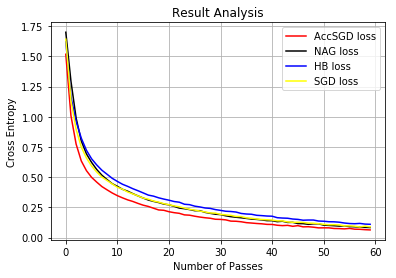

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
 
#这里导入你自己的数据
# x_axix=xxAdam.tolist()
# #x_axix1=xxAccSGD.tolist()
# #y_axix1=yymomentum.tolist()
# y_axix2=yySGD.tolist()
# y_axix3=yyNAG.tolist()
# y_axix4=yyHB.tolist()
# #print("yyAccSGD=",yySGD)
# #print("yySGD=",yyAccSGD)
# #print("yyAdam=",yyAdam)
# y_axix5=yyAccSGD.tolist()
# y_axix6=yyAdam.tolist()
#x_axix，train_pn_dis这些都是长度相同的list()
 
#开始画图
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
#plt.plot(x_axix, y_axix1, color='red', label='momentum loss')
plt.plot(x_axix, yyAccSGD, color='red', label='AccSGD loss')
plt.plot(x_axix, yyNAG, color='black', label='NAG loss')
plt.plot(x_axix, yyHB, color='blue', label='HB loss')
plt.plot(x_axix, yySGD, color='yellow', label='SGD loss')
#plt.plot(x_axix, yyAdam, color='skyblue', label='Adam loss')
plt.legend() # 显示图例
 
plt.xlabel('Number of Passes')
plt.ylabel('Cross Entropy')
plt.grid(axis='both')
plt.savefig("16 20.pdf")
plt.show()

In [0]:
from google.colab import files

files.download("./16 20.pdf")
